Assumptions:
- no wrong charging, discarding all negative charges
- prediction is made upon admission, take only the admission date data
- operation mapping is correct 
- ignoring the frequency of diseases clusters frequency (cluster features is just binary var)
- race recategorization teochew, hainan as chinese

Processing:
- filtering
- handling NA
- feature synthesis for diseases and birth date
- outliers treatment
- features scaling 

In [ ]:
import pandas as pd 
import re 
import numpy as np 
from transformers import pipeline
import torch 
from dateutil.relativedelta import relativedelta
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm 
import h2o
from h2o.automl import H2OAutoML
from sklearn.linear_model import LinearRegression
import spacy 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dir = '/home/huishan/Downloads/DBix_POC_SJMC_AngioPTCA'
randomstate = 4321

/home/huishan/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/huishan/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [ ]:
df_17 = pd.read_excel(dir+f'/POC_AngioPTCA_SJMC_UAT_2017.xlsx')
df_18 = pd.read_excel(dir+f'/POC_AngioPTCA_SJMC_UAT_2018.xlsx')
df_19 = pd.read_excel(dir+f'/POC_AngioPTCA_SJMC_UAT_2019.xlsx')
df_20 = pd.read_excel(dir+f'/POC_AngioPTCA_SJMC_UAT_2020.xlsx')

df_17.drop_duplicates(subset=[x for x in df_17.columns if x!='OperationOrderDate'], inplace=True)
df_18.drop_duplicates(subset=[x for x in df_18.columns if x!='OperationOrderDate'], inplace=True)
df_19.drop_duplicates(subset=[x for x in df_19.columns if x!='OperationOrderDate'], inplace=True)
df_20.drop_duplicates(subset=[x for x in df_20.columns if x!='OperationOrderDate'], inplace=True)

df_17.reset_index(drop=True, inplace=True)
df_18.reset_index(drop=True, inplace=True)
df_19.reset_index(drop=True, inplace=True)
df_20.reset_index(drop=True, inplace=True)

dropped_cols = ['ProcedureDescription', 'ItemOrderedDate']
df_17.drop(columns=dropped_cols, inplace=True)
df_18.drop(columns=dropped_cols, inplace=True)
df_19.drop(columns=dropped_cols, inplace=True)
df_20.drop(columns=dropped_cols, inplace=True)

obj_cols = [x for x in df_17.columns if df_17[x].dtype=='O']
df_17[obj_cols] = df_17[obj_cols].apply(lambda x: x.str.upper())
df_18[obj_cols] = df_18[obj_cols].apply(lambda x: x.str.upper())
df_19[obj_cols] = df_19[obj_cols].apply(lambda x: x.str.upper())
df_20[obj_cols] = df_20[obj_cols].apply(lambda x: x.str.upper())

In [ ]:
df_17.columns

Index(['MRN', 'Age', 'Gender', 'Race', 'MaritalStatus', 'Weight', 'Height',
       'BMI', 'ClinicalHistory', 'Diagnosis', 'VisitID', 'OperationOrderDate',
       'Operation', 'ItemBillingGroup', 'ItemDescription', 'ItemQuantity',
       'ItemChargeCost'],
      dtype='object')

In [ ]:
print("Before Processing:")
print("Number of unique MRN:")
print(2017, "-", df_17.MRN.nunique())
print(2018, "-", df_18.MRN.nunique())
print(2019, "-", df_19.MRN.nunique())
print(2020, "-", df_20.MRN.nunique())
num_MRN = df_17.MRN.nunique()+df_18.MRN.nunique()+df_19.MRN.nunique()+df_20.MRN.nunique()
print("Total -", num_MRN)
print("Number of unique VisitID:")
print(2017, "-", df_17["VisitID"].nunique())
print(2018, "-", df_18["VisitID"].nunique())
print(2019, "-", df_19["VisitID"].nunique())
print(2020, "-", df_20["VisitID"].nunique())
num_visitID =  df_17["VisitID"].nunique()+df_18["VisitID"].nunique()+df_19["VisitID"].nunique()+df_20["VisitID"].nunique()
print("Total -", num_visitID)

Before Processing:
Number of unique MRN:
2017 - 700
2018 - 771
2019 - 937
2020 - 761
Total - 3169
Number of unique VisitID:
2017 - 727
2018 - 798
2019 - 976
2020 - 787
Total - 3288


In [ ]:
billing_groups = set(list(df_17["ItemBillingGroup"].str.upper().unique())+list(df_18["ItemBillingGroup"].str.upper().unique())+list(df_19["ItemBillingGroup"].str.upper().unique())+list(df_20["ItemBillingGroup"].str.upper().unique()))
billing_groups

{'ACCOMMODATION',
 'ANAESTHESIA',
 'ANASTHESIOLOGIST FEE',
 'BASIC NURSING CARE',
 'BLOOD BANK',
 'CASH DEPOSIT ',
 'CLINICAL PROCEDURES',
 'CONSUMABLES',
 'CONTRA PAYMENTS',
 'DEBIT ACCOUNT',
 'DEDUCTION',
 'DISCOUNT',
 'DOCTOR DISCOUNT',
 'DOWN PAYMENT',
 'EXAMINATION FEE',
 'GST',
 'INSTRUMENT SETS',
 'INVESTIGATION',
 'MEDICATION',
 'MISCELLANEOUS SERVICE',
 'OPERATIVE THEATER FEES',
 'PATIENT CN/DN',
 'PROCEDURES',
 'SURGEON FEE'}

In [ ]:
non_items_billing_groups = [
    "CASH DEPOSIT", 
    "DEDUCTION", 
    "DEBIT ACCOUNT", 
    "Cash Deposit ", 
    "DOWN PAYMENT", 
    "PATIENT CN/DN",
    "GST",
    "DISCOUNT",
    "DOCTOR DISCOUNT",
    "CONTRA PAYMENTS"
]

filtered_df_17 = df_17[~df_17["ItemBillingGroup"].isin(non_items_billing_groups)]
filtered_df_18 = df_18[~df_18["ItemBillingGroup"].isin(non_items_billing_groups)]
filtered_df_19 = df_19[~df_19["ItemBillingGroup"].isin(non_items_billing_groups)]
filtered_df_20 = df_20[~df_20["ItemBillingGroup"].isin(non_items_billing_groups)]

filtered_df_17 = filtered_df_17[filtered_df_17['ItemChargeCost']>0]
filtered_df_18 = filtered_df_18[filtered_df_18['ItemChargeCost']>0]
filtered_df_19 = filtered_df_19[filtered_df_19['ItemChargeCost']>0]
filtered_df_20 = filtered_df_20[filtered_df_20['ItemChargeCost']>0]

In [ ]:
ops_lst = list(set(list(df_17['Operation'].unique()) + list(df_18['Operation'].unique()) + list(df_19['Operation'].unique()) + list(df_20['Operation'].unique())))
ops_lst

['LAP CHOLE WITH CHOLANGIOGRAM',
 'LEFT ARM ANGIOGRAM KIV BALLOON ANGIOPLASTY',
 'LAPAROSCOPIC CHOLEY WITH CHOLANGIOGRAM',
 'LAPAROSCOPIC  CHOLEYCYSTECTOMY & CHOLANGIOGRAM',
 'LAPAROSCOPIC LIVER RESECTION, CHOLECYSTECTOMY & CHOLANGIOGRAM',
 'LAP CHOLEY WITH CHOLANGIOGRAM, OGDS',
 'CEREBRAL ANGIOGRAM & STENTING',
 'CHOLECYSTECTOMY CHOLANGIOGRAM',
 'LAPAROTOMY CHOLECYSTECTOMY WITH CHOLANGIOGRAM',
 'LAP CHOLECYSTECTOMY AND CHOLANGIOGRAM',
 'LAPAROSCOPIC CHOLECYSTECTOMY WITH  CHOLANGIOGRAM & OGDS',
 'LAP CHOLEY WITH CHOLANGIOGRAM',
 'LAPAROSCOPIC CHOLECYSTECTOMY KIV CHOLANGIOGRAM',
 'OPEN CHOLEYCYSTECTOMY WITH CHOLANGIOGRAM',
 'LAPAROTOMY  CHOLECYSTECTOMY KIV CHOLANGIOGRAM WITH F/SECTION',
 'UPPER / LOWER LIMB ANGIOGRAM',
 'LAPAROSCOPIC CHOLECYSTECTOMY & CHOLANGIOGRAM',
 'LAPAROSCOPIC CHOLECYSTECTOMY, CHOLANGIOGRAM',
 'LAPAROSCOPIC CHOLECYSTECTOMY WITH CHOLANGIOGRAME',
 'ANGIOGRAM - NON NEURO',
 'OPEN CHOLEYCECTOMY WITH CHOLANGIOGRAM AND LIVER RESECTION',
 'LV/CORONARY ANGIOGRAM',
 'LAPARA

In [ ]:
encoder = SentenceTransformer("all-mpnet-base-v2")
ops_embeddings = encoder.encode(ops_lst)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{2: ['LAP CHOLE WITH CHOLANGIOGRAM',
  'LAP CHOLEY WITH CHOLANGIOGRAM, OGDS',
  'LAP CHOLEY WITH CHOLANGIOGRAM',
  'LAP CHOLEY & CHOLANGIOGRAM',
  'LAP CHOLEY CHOLANGIOGRAM',
  'OPEN CHOLEY WITH CHOLANGIOGRAM'],
 9: ['LEFT ARM ANGIOGRAM KIV BALLOON ANGIOPLASTY'],
 5: ['LAPAROSCOPIC CHOLEY WITH CHOLANGIOGRAM',
  'LAPAROSCOPIC  CHOLEYCYSTECTOMY & CHOLANGIOGRAM',
  'OPEN CHOLEYCYSTECTOMY WITH CHOLANGIOGRAM',
  'OPEN CHOLEYCECTOMY WITH CHOLANGIOGRAM AND LIVER RESECTION',
  'OPEN CHOLEYCECTOMY WITH CHOLANGIOGRAM',
  'LIVER RESECTION, CHOLANGIOGRAM'],
 7: ['LAPAROSCOPIC LIVER RESECTION, CHOLECYSTECTOMY & CHOLANGIOGRAM',
  'CHOLECYSTECTOMY CHOLANGIOGRAM',
  'LAPAROTOMY CHOLECYSTECTOMY WITH CHOLANGIOGRAM',
  'LAP CHOLECYSTECTOMY AND CHOLANGIOGRAM',
  'LAPAROSCOPIC CHOLECYSTECTOMY WITH  CHOLANGIOGRAM & OGDS',
  'LAPAROSCOPIC CHOLECYSTECTOMY & CHOLANGIOGRAM',
  'LAPAROSCOPIC CHOLECYSTECTOMY, CHOLANGIOGRAM',
  'LAPAROSCOPIC CHOLECYSTECTOMY WITH CHOLANGIOGRAME',
  'LAPARASCOPIC CHOLECYSTECTOMY & C

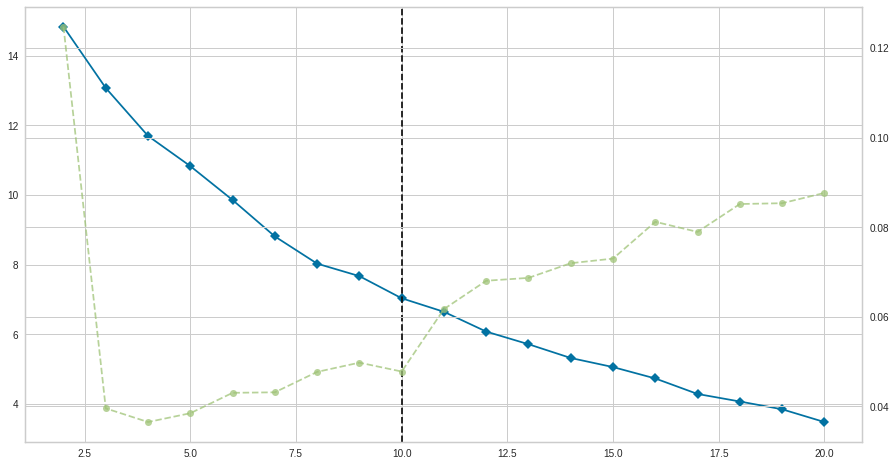

In [ ]:
visualizer = KElbowVisualizer(KMeans(random_state=randomstate), k=(2,21))
plt.figure(figsize = (15,8))
visualizer.fit(ops_embeddings)        
k_optimal = visualizer.elbow_value_

ops_clusters_dic = dict(zip(ops_lst, KMeans(n_clusters=k_optimal, random_state=randomstate).fit_predict(ops_embeddings)))

insp = {}
for k, v in dict(zip(ops_lst, KMeans(n_clusters=k_optimal, random_state=randomstate).fit_predict(ops_embeddings))).items():
    if v not in insp.keys():
        insp[v] = [k]
    else:
        insp[v].append(k)
insp

In [ ]:
distinct_ops = {}
for i, df in enumerate([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20]):
    distinct_ops[2017+i] = []
    for id in df.MRN.unique():
        if df[df.MRN==id]['Operation'].nunique()>1 and df[df.MRN==id]['VisitID'].nunique()==1:
            distinct_ops[2017+i].append({id: df[df.MRN==id]['Operation'].unique().tolist()})
distinct_ops

{2017: [{101327322: ['CEREBRAL ANGIOGRAM & STENTING', 'ANGIOGRAM - NEURO']},
  {100972772: ['ANGIOGRAM - NEURO', 'CEREBRAL ANGIOGRAM & STENTING']},
  {101023863: ['LV/CORONARY ANGIOGRAM', 'CORONARY ANGIOGRAM']}],
 2018: [{101231156: ['LAPAROSCOPIC CHOLECYSTECTOMY & CHOLANGIOGRAM',
    'LAP CHOLEY WITH CHOLANGIOGRAM']}],
 2019: [{101347318: ['LAPAROSCOPIC CHOLECYSTECTOMY WITH CHOLANGIOGRAM',
    'LV/CORONARY ANGIOGRAM']},
  {101272220: ['LV/CORONARY ANGIOGRAM', 'KIV PTCA']},
  {100641403: ['ANGIOGRAM', 'LV/CORONARY ANGIOGRAM']}],
 2020: [{101089532: ['LAP CHOLE WITH CHOLANGIOGRAM',
    'LAPAROSCOPIC CHOLECYSTECTOMY WITH CHOLANGIOGRAM']}]}

In [ ]:
filtered_df_17["Operation_Clusters"] = filtered_df_17["Operation"].map(ops_clusters_dic)
filtered_df_18["Operation_Clusters"] = filtered_df_18["Operation"].map(ops_clusters_dic)
filtered_df_19["Operation_Clusters"] = filtered_df_19["Operation"].map(ops_clusters_dic)
filtered_df_20["Operation_Clusters"] = filtered_df_20["Operation"].map(ops_clusters_dic)

In [ ]:
filtered_clus = []
for k, v in insp.items():
    if not any("ANGIOGRAM" in q.split() for q in v) and not any("PTCA" in q.split() for q in v):
        filtered_clus.append(k)

In [ ]:
mrn_to_removed = {}
for i, df in enumerate([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20]):
    mrn_to_removed[2017+i] = {'patient': [], 'visit': []}
    for id in df.MRN.unique():
        df_ = df[df.MRN==id]
        for visit in df_.VisitID.unique():
            if df_[df_.VisitID==visit]['Operation_Clusters'].isin(filtered_clus).any():
                mrn_to_removed[2017+i]['patient'].append(id)
                mrn_to_removed[2017+i]['visit'].append(visit)

count_mrn_to_removed = {}
for k, v in mrn_to_removed.items():
    count_mrn_to_removed[k] = (len(mrn_to_removed[k]['patient']), len(mrn_to_removed[k]['visit']))
count_mrn_to_removed

{2017: (18, 18), 2018: (54, 54), 2019: (85, 85), 2020: (72, 72)}

In [ ]:
for i, j in zip(mrn_to_removed[2017]['patient'], mrn_to_removed[2017]['visit']):
    filtered_df_17 = filtered_df_17[~(filtered_df_17.MRN==i) & ~(filtered_df_17.VisitID==j)]
for i, j in zip(mrn_to_removed[2018]['patient'], mrn_to_removed[2018]['visit']):
    filtered_df_18 = filtered_df_18[~(filtered_df_18.MRN==i) & ~(filtered_df_18.VisitID==j)]
for i, j in zip(mrn_to_removed[2019]['patient'], mrn_to_removed[2019]['visit']):
    filtered_df_19 = filtered_df_19[~(filtered_df_19.MRN==i) & ~(filtered_df_19.VisitID==j)]
for i, j in zip(mrn_to_removed[2020]['patient'], mrn_to_removed[2020]['visit']):
    filtered_df_20 = filtered_df_20[~(filtered_df_20.MRN==i) & ~(filtered_df_20.VisitID==j)]

In [ ]:
print("Number of unique MRN:")
print(2017, "-", filtered_df_17.MRN.nunique())
print(2018, "-", filtered_df_18.MRN.nunique())
print(2019, "-", filtered_df_19.MRN.nunique())
print(2020, "-", filtered_df_20.MRN.nunique())
num_MRN = filtered_df_17.MRN.nunique()+filtered_df_18.MRN.nunique()+filtered_df_19.MRN.nunique()+filtered_df_20.MRN.nunique()
print("Total -", num_MRN)
print("Number of unique VisitID:")
print(2017, "-", filtered_df_17["VisitID"].nunique())
print(2018, "-", filtered_df_18["VisitID"].nunique())
print(2019, "-", filtered_df_19["VisitID"].nunique())
print(2020, "-", filtered_df_20["VisitID"].nunique())
num_visitID =  filtered_df_17["VisitID"].nunique()+filtered_df_18["VisitID"].nunique()+filtered_df_19["VisitID"].nunique()+filtered_df_20["VisitID"].nunique()
print("Total -", num_visitID)

Number of unique MRN:
2017 - 682
2018 - 717
2019 - 852
2020 - 689
Total - 2940
Number of unique VisitID:
2017 - 709
2018 - 743
2019 - 890
2020 - 715
Total - 3057


In [ ]:
if num_visitID!=num_MRN:
    print("After processing")
    print("Number of repeating visits:", num_visitID-num_MRN)
    print("2017 -", filtered_df_17["VisitID"].nunique()-filtered_df_17["MRN"].nunique())
    print("2018 -", filtered_df_18["VisitID"].nunique()-filtered_df_18["MRN"].nunique())
    print("2019 -", filtered_df_19["VisitID"].nunique()-filtered_df_19["MRN"].nunique())
    print("2020 -", filtered_df_20["VisitID"].nunique()-filtered_df_20["MRN"].nunique())

    num_uniq_visitID_by_MRN_17 = filtered_df_17.groupby(['MRN'])['VisitID'].nunique()
    if not num_uniq_visitID_by_MRN_17[num_uniq_visitID_by_MRN_17>1].empty:
        print(num_uniq_visitID_by_MRN_17[num_uniq_visitID_by_MRN_17>1])
    num_uniq_visitID_by_MRN_18 = filtered_df_18.groupby(['MRN'])['VisitID'].nunique()
    if not num_uniq_visitID_by_MRN_18[num_uniq_visitID_by_MRN_18>1].empty:
        print(num_uniq_visitID_by_MRN_18[num_uniq_visitID_by_MRN_18>1])
    num_uniq_visitID_by_MRN_19 = filtered_df_19.groupby(['MRN'])['VisitID'].nunique()
    if not num_uniq_visitID_by_MRN_19[num_uniq_visitID_by_MRN_19>1].empty:
        print(num_uniq_visitID_by_MRN_19[num_uniq_visitID_by_MRN_19>1])
    num_uniq_visitID_by_MRN_20 = filtered_df_20.groupby(['MRN'])['VisitID'].nunique()
    if not num_uniq_visitID_by_MRN_20[num_uniq_visitID_by_MRN_20>1].empty:
        print(num_uniq_visitID_by_MRN_20[num_uniq_visitID_by_MRN_20>1])

After processing
Number of repeating visits: 117
2017 - 27
2018 - 26
2019 - 38
2020 - 26
MRN
100039793    2
100077149    2
100130280    2
100139961    2
100223186    2
100233119    3
100247173    2
100354094    2
100357192    2
100496030    2
100551540    2
100612329    2
100703336    2
100722259    2
100743655    2
100983786    2
101066719    2
101144907    2
101157650    2
101186905    2
101201503    2
101232141    2
101314652    2
101319501    2
101322224    2
101340976    2
Name: VisitID, dtype: int64
MRN
100111889    2
100155685    2
100316072    2
100338147    2
100436847    2
100551819    2
100584283    2
100633989    2
100683495    2
100719680    2
100951103    2
100982253    2
101030747    2
101055852    2
101095800    2
101372613    2
101374640    2
101379770    2
101383450    2
101384277    2
101385505    2
101387353    2
101389395    2
101389703    2
101392628    3
Name: VisitID, dtype: int64
MRN
100019482    2
100024142    2
100086991    2
100139961    2
100161876    2
100

In [ ]:
def calc_age_in_years(row):
    row['Age']
    orderDate = row['OperationOrderDate']
    age = row['Age']
    splitting = re.split('[a-zA-Z]+', age)
    year = int(splitting[0].strip())
    month = int(splitting[1].strip())
    day = int(splitting[2].strip())
    bod = orderDate-relativedelta(years=year, months=month, days=day)
    return (orderDate-bod).days/365.25

filtered_df_17['Age In Years'] = filtered_df_17.apply(calc_age_in_years, axis=1)
filtered_df_18['Age In Years'] = filtered_df_18.apply(calc_age_in_years, axis=1)
filtered_df_19['Age In Years'] = filtered_df_19.apply(calc_age_in_years, axis=1)
filtered_df_20['Age In Years'] = filtered_df_20.apply(calc_age_in_years, axis=1)

In [ ]:
nlp = spacy.load("en_core_web_md")
def date_removed(text):
    doc = nlp(text)
    for entity in doc.ents:
        if entity.label_=="DATE":
            text = text.replace(entity.text, "")
    return text

def diseases_cleaning(filtered_df):
    filtered_df["ClinicalHistory"] = filtered_df["ClinicalHistory"].apply(lambda x: "" if "FATHER" in x else x)
    filtered_df["Diagnosis"] = filtered_df["Diagnosis"].apply(lambda x: "" if "FATHER" in x else x)
    uniq_lst = list(map(date_removed, filtered_df["ClinicalHistory"].unique().tolist()))
    uniq_lst = uniq_lst + list(map(date_removed, filtered_df["Diagnosis"].unique().tolist()))
    formatted_lst = list(map(lambda x: re.sub("\d+/\d+/\d+", "", x), uniq_lst))
    formatted_lst = list(map(lambda x: re.sub("[0-9]{4}", "", x), formatted_lst))
    formatted_lst = list(map(lambda x: x.replace("()", ""), formatted_lst))
    formatted_lst = list(map(lambda x: re.split("\d+\)|\d+\.|\d+ \.| \& | \+ ", x), formatted_lst))
    formatted_lst = [list(map(lambda x: re.sub(r'[^\w\s]', "", x.strip().replace(" and", "")), y)) for y in formatted_lst]
    formatted_lst = [[x for x in y if x!=""] for y in formatted_lst]
    return dict(zip(uniq_lst, formatted_lst))

filtered_df_17["ClinicalHistory"] = filtered_df_17["ClinicalHistory"].apply(lambda x: str(x).upper())
filtered_df_17["Diagnosis"] = filtered_df_17["Diagnosis"].apply(lambda x: str(x).upper())
filtered_df_18["ClinicalHistory"] = filtered_df_18["ClinicalHistory"].apply(lambda x: str(x).upper())
filtered_df_18["Diagnosis"] = filtered_df_18["Diagnosis"].apply(lambda x: str(x).upper())
filtered_df_19["ClinicalHistory"] = filtered_df_19["ClinicalHistory"].apply(lambda x: str(x).upper())
filtered_df_19["Diagnosis"] = filtered_df_19["Diagnosis"].apply(lambda x: str(x).upper())
filtered_df_20["ClinicalHistory"] = filtered_df_20["ClinicalHistory"].apply(lambda x: str(x).upper())
filtered_df_20["Diagnosis"] = filtered_df_20["Diagnosis"].apply(lambda x: str(x).upper())

filtered_df_17["Clinical History Cleaned"] = filtered_df_17["ClinicalHistory"].map(diseases_cleaning(filtered_df_17))
filtered_df_18["Clinical History Cleaned"] = filtered_df_18["ClinicalHistory"].map(diseases_cleaning(filtered_df_18))
filtered_df_19["Clinical History Cleaned"] = filtered_df_19["ClinicalHistory"].map(diseases_cleaning(filtered_df_19))
filtered_df_20["Clinical History Cleaned"] = filtered_df_20["ClinicalHistory"].map(diseases_cleaning(filtered_df_20))

filtered_df_17["Diagnosis Cleaned"] = filtered_df_17["Diagnosis"].map(diseases_cleaning(filtered_df_17))
filtered_df_18["Diagnosis Cleaned"] = filtered_df_18["Diagnosis"].map(diseases_cleaning(filtered_df_18))
filtered_df_19["Diagnosis Cleaned"] = filtered_df_19["Diagnosis"].map(diseases_cleaning(filtered_df_19))
filtered_df_20["Diagnosis Cleaned"] = filtered_df_20["Diagnosis"].map(diseases_cleaning(filtered_df_20))

In [ ]:
def joined_features(df, feature_to_join):
       grouping_keys = [
              'MRN', 'Age', 'Gender', 'Race', 
              'MaritalStatus', 'Weight', 'Height',
              'BMI', 'VisitID', 'ItemBillingGroup', 'ItemDescription', 
              'ItemChargeCost', 'ItemQuantity', 'OperationOrderDate', 'Operation'
       ]
       df = df.sort_values(by=["MRN", "OperationOrderDate"])
       df.reset_index(drop=True, inplace=True)
       joined_clinical_history = pd.DataFrame(df.groupby(grouping_keys).agg({feature_to_join: 'sum'}))
       res_df = df.merge(joined_clinical_history, how='left', on=grouping_keys, suffixes=('', ' Joined'))
       res_df[feature_to_join] = res_df[f"{feature_to_join} Joined"].apply(lambda x: list(set(x)) if type(x)==list else [])
       res_df.drop(columns=[f"{feature_to_join} Joined"], inplace=True)
       res_df.drop_duplicates(subset=['VisitID', 'ItemBillingGroup', 'ItemDescription', 'ItemChargeCost', 'ItemQuantity', 'OperationOrderDate'], inplace=True)
       return res_df

for feature in ["Clinical History Cleaned", "Diagnosis Cleaned"]:
       filtered_df_17 = joined_features(filtered_df_17, feature)
       filtered_df_18 = joined_features(filtered_df_18, feature)
       filtered_df_19 = joined_features(filtered_df_19, feature)
       filtered_df_20 = joined_features(filtered_df_20, feature)

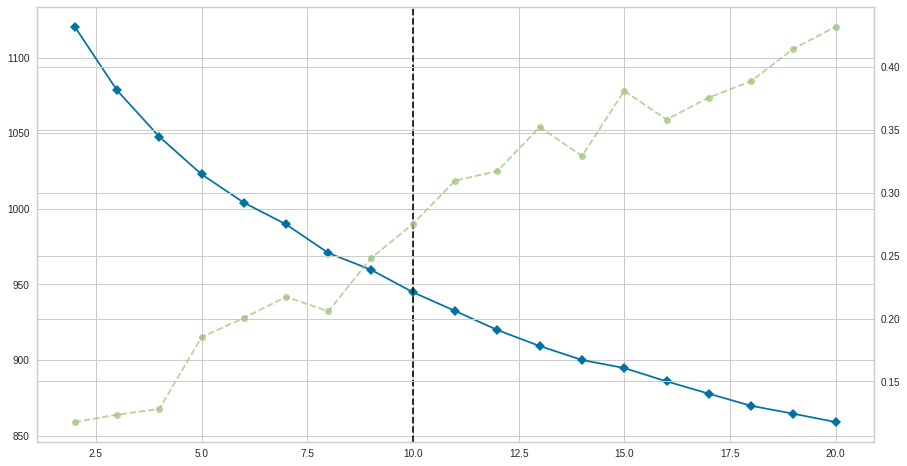

In [ ]:
# Clustering code
def flatten_lst(lst):
    res_lst = []
    for l in lst:
        if type(l)!=list:
            l = [l]
        res_lst += l
    return res_lst

diseases_lst_17 = list(set(flatten_lst(filtered_df_17["Clinical History Cleaned"].values.tolist()))) + list(set(flatten_lst(filtered_df_17["Diagnosis Cleaned"].values.tolist())))
diseases_lst_18 = list(set(flatten_lst(filtered_df_18["Clinical History Cleaned"].values.tolist()))) + list(set(flatten_lst(filtered_df_18["Diagnosis Cleaned"].values.tolist())))
diseases_lst_19 = list(set(flatten_lst(filtered_df_19["Clinical History Cleaned"].values.tolist()))) + list(set(flatten_lst(filtered_df_19["Diagnosis Cleaned"].values.tolist())))
diseases_lst_20 = list(set(flatten_lst(filtered_df_20["Clinical History Cleaned"].values.tolist()))) + list(set(flatten_lst(filtered_df_20["Diagnosis Cleaned"].values.tolist())))
diseases_lst = list(set(diseases_lst_17+diseases_lst_18+diseases_lst_19+diseases_lst_20))

encoder = SentenceTransformer("all-mpnet-base-v2")
diseases_embeddings = encoder.encode(diseases_lst)

visualizer = KElbowVisualizer(KMeans(random_state=randomstate), k=(2,21))
plt.figure(figsize = (15,8))
visualizer.fit(diseases_embeddings) 
k_optimal_d = visualizer.elbow_value_

In [ ]:
diseases_clusters_dic = dict(zip(diseases_lst, KMeans(n_clusters=k_optimal_d, random_state=randomstate).fit_predict(diseases_embeddings)))

def assigning_clusters(lst, dic):
    res = []
    if not isinstance(lst, float):
        for ele in lst:
            res.append(dic[ele])
        return list(set(res))
    else: 
        return []

filtered_df_17["Clinical History Clusters"] = filtered_df_17["Clinical History Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_17["Diagnosis Clusters"] = filtered_df_17["Diagnosis Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_18["Clinical History Clusters"] = filtered_df_18["Clinical History Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_18["Diagnosis Clusters"] = filtered_df_18["Diagnosis Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_19["Clinical History Clusters"] = filtered_df_19["Clinical History Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_19["Diagnosis Clusters"] = filtered_df_19["Diagnosis Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_20["Clinical History Clusters"] = filtered_df_20["Clinical History Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))
filtered_df_20["Diagnosis Clusters"] = filtered_df_20["Diagnosis Cleaned"].apply(lambda x: assigning_clusters(x, diseases_clusters_dic))

In [ ]:
def new_cols(filtered_df, feature):
    vars = []
    for i in range(k_optimal_d):
        vars.append(f"{feature} {i}")
    filtered_df[vars] = 0
    for idx, row in filtered_df.iterrows():
        clusters_lst = row[feature]
        if clusters_lst:
            for ele in clusters_lst:
                filtered_df.loc[idx, f"{feature} {ele}"] = 1
    return filtered_df

filtered_df_17 = new_cols(filtered_df_17, "Clinical History Clusters")
filtered_df_18 = new_cols(filtered_df_18, "Clinical History Clusters")
filtered_df_19 = new_cols(filtered_df_19, "Clinical History Clusters")
filtered_df_20 = new_cols(filtered_df_20, "Clinical History Clusters")

filtered_df_17 = new_cols(filtered_df_17, "Diagnosis Clusters")
filtered_df_18 = new_cols(filtered_df_18, "Diagnosis Clusters")
filtered_df_19 = new_cols(filtered_df_19, "Diagnosis Clusters")
filtered_df_20 = new_cols(filtered_df_20, "Diagnosis Clusters")


In [ ]:
features_to_agg = ["MRN", "VisitID"]

filtered_df_17 = filtered_df_17.merge(pd.DataFrame(filtered_df_17.groupby(features_to_agg)["ItemChargeCost"].sum()), how="left", on=features_to_agg, suffixes=["", " Aggregated"])
filtered_df_18 = filtered_df_18.merge(pd.DataFrame(filtered_df_18.groupby(features_to_agg)["ItemChargeCost"].sum()), how="left", on=features_to_agg, suffixes=["", " Aggregated"])
filtered_df_19 = filtered_df_19.merge(pd.DataFrame(filtered_df_19.groupby(features_to_agg)["ItemChargeCost"].sum()), how="left", on=features_to_agg, suffixes=["", " Aggregated"])
filtered_df_20 = filtered_df_20.merge(pd.DataFrame(filtered_df_20.groupby(features_to_agg)["ItemChargeCost"].sum()), how="left", on=features_to_agg, suffixes=["", " Aggregated"])

filtered_df_17 = filtered_df_17.merge(pd.DataFrame(filtered_df_17.groupby(features_to_agg)["OperationOrderDate"].min()), how="left", on=features_to_agg, suffixes=["", " Min"])
filtered_df_18 = filtered_df_18.merge(pd.DataFrame(filtered_df_18.groupby(features_to_agg)["OperationOrderDate"].min()), how="left", on=features_to_agg, suffixes=["", " Min"])
filtered_df_19 = filtered_df_19.merge(pd.DataFrame(filtered_df_19.groupby(features_to_agg)["OperationOrderDate"].min()), how="left", on=features_to_agg, suffixes=["", " Min"])
filtered_df_20 = filtered_df_20.merge(pd.DataFrame(filtered_df_20.groupby(features_to_agg)["OperationOrderDate"].min()), how="left", on=features_to_agg, suffixes=["", " Min"])

In [ ]:
def splitting_date(filtered_df):
    filtered_df["Ordered Date Day"] = filtered_df["OperationOrderDate"].apply(lambda x: x.day)
    filtered_df["Ordered Date Month"] = filtered_df["OperationOrderDate"].apply(lambda x: x.month)
    filtered_df['NumYear'] = filtered_df["OperationOrderDate"].apply(lambda x: x.year-2017)
    return filtered_df

filtered_df_17 = splitting_date(filtered_df_17)
filtered_df_18 = splitting_date(filtered_df_18)
filtered_df_19 = splitting_date(filtered_df_19)
filtered_df_20 = splitting_date(filtered_df_20)

In [ ]:
print('Gender:', set(list(filtered_df_17.Gender.unique()) + list(filtered_df_18.Gender.unique()) + list(filtered_df_19.Gender.unique()) + list(filtered_df_20.Gender.unique())))
print('MaritalStatus:', set(list(filtered_df_17.MaritalStatus.unique()) + list(filtered_df_18.MaritalStatus.unique()) + list(filtered_df_19.MaritalStatus.unique()) + list(filtered_df_20.MaritalStatus.unique())))
print('Race:', set(list(filtered_df_17.Race.unique()) + list(filtered_df_18.Race.unique()) + list(filtered_df_19.Race.unique()) + list(filtered_df_20.Race.unique())))

Gender: {'MALE', 'FEMALE'}
MaritalStatus: {'MARRIED ', nan, 'WIDOWED', 'DIVORCED', 'SINGLE'}
Race: {nan, 'IBAN ATAU SEA DAYAK', 'KADAZAN', 'PORTUGESE', 'AUSTRALIA', 'INDONESIA', 'SRI LANKA', 'BRITISH', 'SIKH', 'HOKKIEN', 'CHINESE', 'SINHALESE', 'OTHERS', 'INDIA MUSLIM', 'SINO-NATIVE', 'INDIAN', 'INDONESIAN', 'JAPANESE', 'EURASIAN', 'MALAY', 'THAI', 'CAUCASIAN', 'TEOCHEW'}


In [ ]:
dialects = [
    "HOKKIEN", 
    "HAINANESE", 
    "TEOCHEW", 
    "FOOCHEW", 
    "HAKKA", 
    "CANTONESE"
]

filtered_df_17["Race"] = filtered_df_17["Race"].apply(lambda x: "CHINESE" if x in dialects else x)
filtered_df_18["Race"] = filtered_df_18["Race"].apply(lambda x: "CHINESE" if x in dialects else x)
filtered_df_19["Race"] = filtered_df_19["Race"].apply(lambda x: "CHINESE" if x in dialects else x)
filtered_df_20["Race"] = filtered_df_20["Race"].apply(lambda x: "CHINESE" if x in dialects else x)

In [ ]:
print(filtered_df_17.drop_duplicates(subset='MRN').Race.value_counts())
print(filtered_df_18.drop_duplicates(subset='MRN').Race.value_counts())
print(filtered_df_19.drop_duplicates(subset='MRN').Race.value_counts())
print(filtered_df_20.drop_duplicates(subset='MRN').Race.value_counts())

CHINESE                389
INDIAN                 135
MALAY                  105
OTHERS                  11
JAPANESE                 2
INDONESIAN               2
SIKH                     2
EURASIAN                 1
AUSTRALIA                1
IBAN ATAU SEA DAYAK      1
SRI LANKA                1
BRITISH                  1
Name: Race, dtype: int64
CHINESE         407
INDIAN          144
MALAY           137
SIKH              4
OTHERS            3
INDONESIAN        2
JAPANESE          2
SINHALESE         1
SINO-NATIVE       1
KADAZAN           1
INDONESIA         1
INDIA MUSLIM      1
Name: Race, dtype: int64
CHINESE       474
INDIAN        207
MALAY         115
SIKH            6
OTHERS          5
INDONESIAN      4
EURASIAN        1
SRI LANKA       1
THAI            1
Name: Race, dtype: int64
CHINESE      354
INDIAN       156
MALAY        124
OTHERS        10
SIKH           3
SRI LANKA      2
EURASIAN       2
SINHALESE      1
CAUCASIAN      1
PORTUGESE      1
Name: Race, dtype: int64


In [ ]:
filtered_df_17.columns

Index(['MRN', 'Age', 'Gender', 'Race', 'MaritalStatus', 'Weight', 'Height',
       'BMI', 'ClinicalHistory', 'Diagnosis', 'VisitID', 'OperationOrderDate',
       'Operation', 'ItemBillingGroup', 'ItemDescription', 'ItemQuantity',
       'ItemChargeCost', 'Operation_Clusters', 'Age In Years',
       'Clinical History Cleaned', 'Diagnosis Cleaned',
       'Clinical History Clusters', 'Diagnosis Clusters',
       'Clinical History Clusters 0', 'Clinical History Clusters 1',
       'Clinical History Clusters 2', 'Clinical History Clusters 3',
       'Clinical History Clusters 4', 'Clinical History Clusters 5',
       'Clinical History Clusters 6', 'Clinical History Clusters 7',
       'Clinical History Clusters 8', 'Clinical History Clusters 9',
       'Diagnosis Clusters 0', 'Diagnosis Clusters 1', 'Diagnosis Clusters 2',
       'Diagnosis Clusters 3', 'Diagnosis Clusters 4', 'Diagnosis Clusters 5',
       'Diagnosis Clusters 6', 'Diagnosis Clusters 7', 'Diagnosis Clusters 8',
       'Dia

In [ ]:
features_to_removed = [
    "Age", "ItemBillingGroup", "ItemDescription", "OperationOrderDate", "ItemQuantity", "OperationOrderDate Min", 
    "ClinicalHistory", "Diagnosis", "Operation_Clusters", "ItemChargeCost", "Diagnosis Cleaned", 
    "Clinical History Cleaned", "VisitID", "Clinical History Clusters", "Diagnosis Clusters"
]

filtered_df_17.sort_values(by=["OperationOrderDate"], inplace=True)
filtered_df_18.sort_values(by=["OperationOrderDate"], inplace=True)
filtered_df_19.sort_values(by=["OperationOrderDate"], inplace=True)
filtered_df_20.sort_values(by=["OperationOrderDate"], inplace=True)

filtered_df_17.drop_duplicates(subset=["MRN", "VisitID"], inplace=True)
filtered_df_17.reset_index(drop=True, inplace=True)
filtered_df_18.drop_duplicates(subset=["MRN", "VisitID"], inplace=True)
filtered_df_18.reset_index(drop=True, inplace=True)
filtered_df_19.drop_duplicates(subset=["MRN", "VisitID"], inplace=True)
filtered_df_19.reset_index(drop=True, inplace=True)
filtered_df_20.drop_duplicates(subset=["MRN", "VisitID"], inplace=True)
filtered_df_20.reset_index(drop=True, inplace=True)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

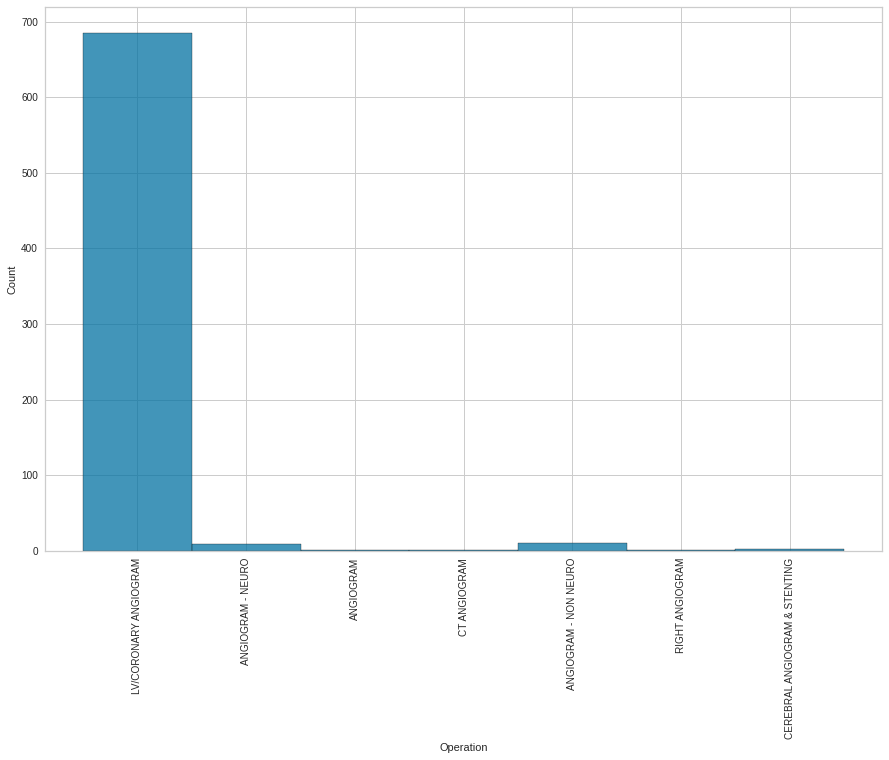

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(x="Operation", data=filtered_df_17)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

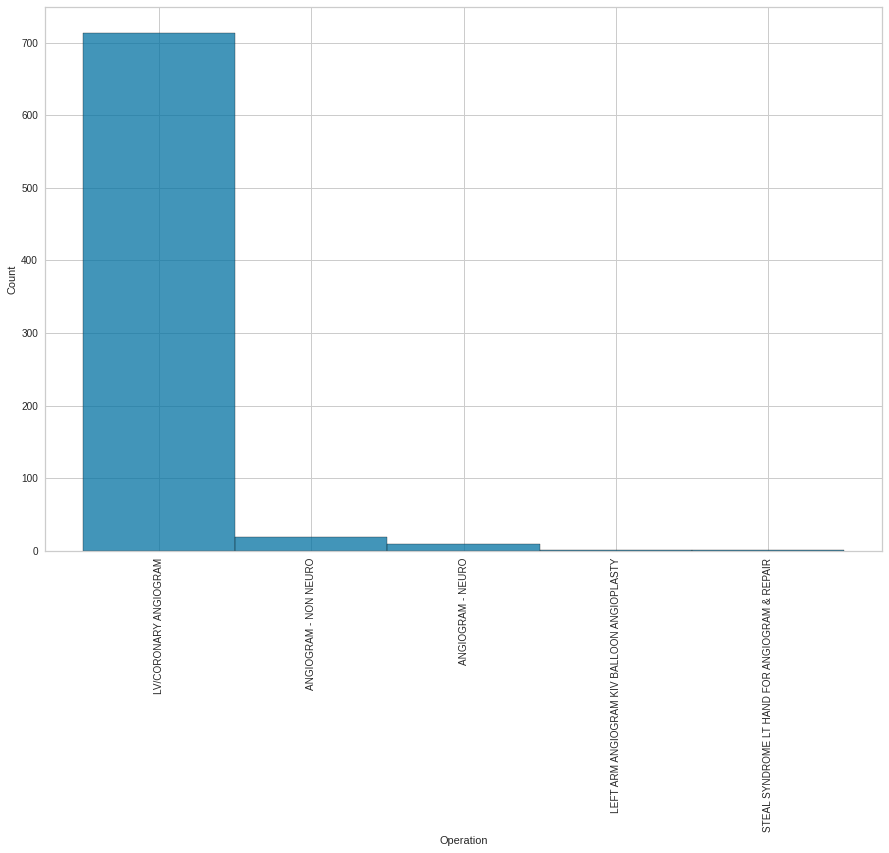

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(x="Operation", data=filtered_df_18)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

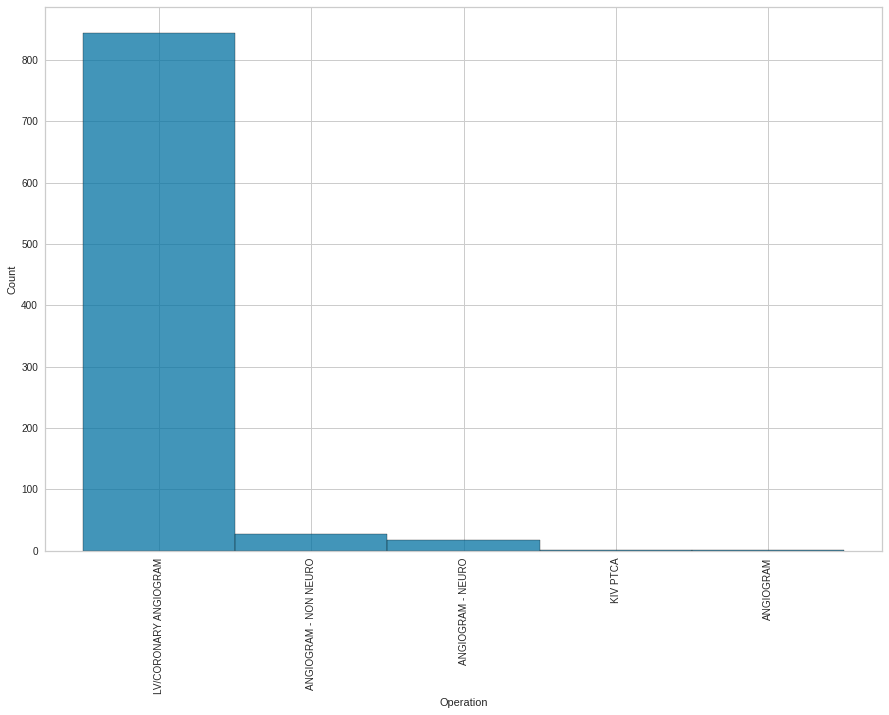

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(x="Operation", data=filtered_df_19)
plt.xticks(rotation=90)

([0, 1, 2, 3],
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

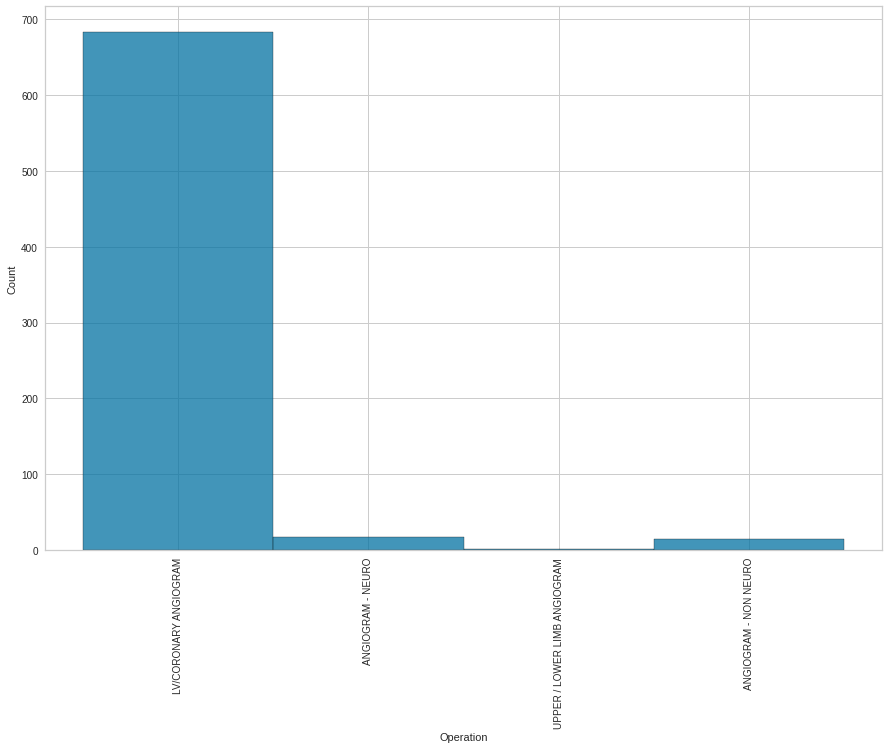

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(x="Operation", data=filtered_df_20)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'LV/CORONARY ANGIOGRAM'),
  Text(1, 0, 'ANGIOGRAM - NEURO'),
  Text(2, 0, 'ANGIOGRAM'),
  Text(3, 0, 'CT ANGIOGRAM'),
  Text(4, 0, 'ANGIOGRAM - NON NEURO'),
  Text(5, 0, 'RIGHT ANGIOGRAM'),
  Text(6, 0, 'CEREBRAL ANGIOGRAM & STENTING'),
  Text(7, 0, 'LEFT ARM ANGIOGRAM KIV BALLOON ANGIOPLASTY'),
  Text(8, 0, 'STEAL SYNDROME LT HAND FOR ANGIOGRAM & REPAIR'),
  Text(9, 0, 'KIV PTCA'),
  Text(10, 0, 'UPPER / LOWER LIMB ANGIOGRAM')])

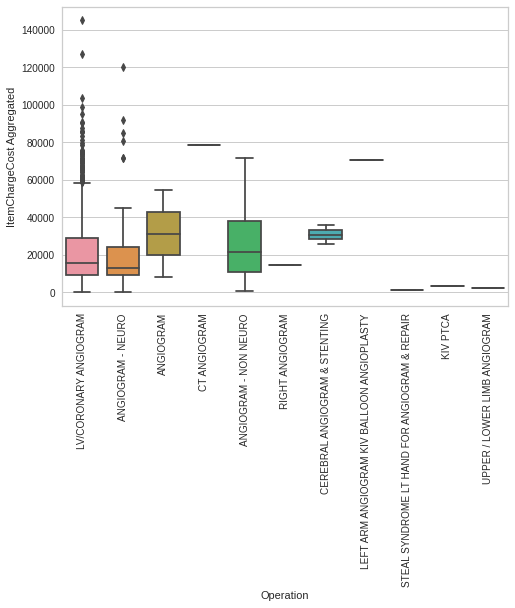

In [ ]:
sns.boxplot(x="Operation", y='ItemChargeCost Aggregated', data=pd.concat([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20]))
plt.xticks(rotation=90)

<Figure size 1080x720 with 0 Axes>

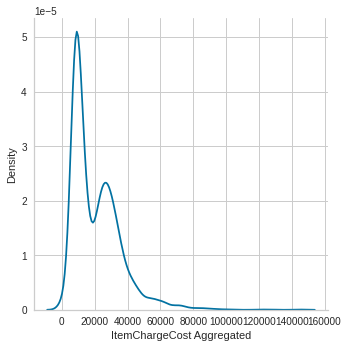

In [ ]:
plt.figure(figsize = (15,10))
sns.displot(pd.concat([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20]), x="ItemChargeCost Aggregated", kind="kde")

/home/huishan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/huishan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/huishan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


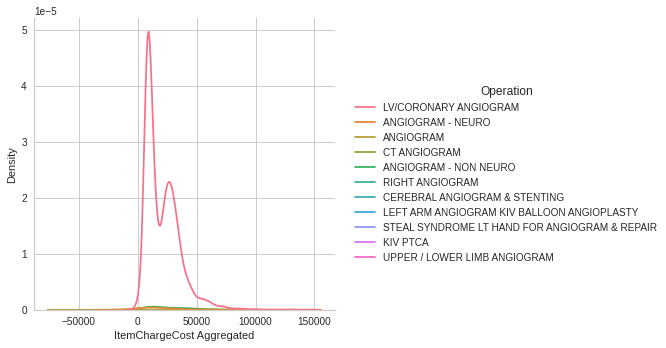

In [ ]:
# plt.figure(figsize = (15,10))
sns.displot(pd.concat([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20]), x="ItemChargeCost Aggregated", kind="kde", hue="Operation")

In [ ]:
filtered_df_17 = filtered_df_17[filtered_df_17.Operation=='LV/CORONARY ANGIOGRAM']
filtered_df_18 = filtered_df_18[filtered_df_18.Operation=='LV/CORONARY ANGIOGRAM']
filtered_df_19 = filtered_df_19[filtered_df_19.Operation=='LV/CORONARY ANGIOGRAM']
filtered_df_20 = filtered_df_20[filtered_df_20.Operation=='LV/CORONARY ANGIOGRAM']

In [ ]:
filtered_df_17.drop(columns=features_to_removed, inplace=True)
filtered_df_18.drop(columns=features_to_removed, inplace=True)
filtered_df_19.drop(columns=features_to_removed, inplace=True)
filtered_df_20.drop(columns=features_to_removed, inplace=True)

In [ ]:
print("Number of records:")
print(2017, "-", filtered_df_17.shape)
print(2018, "-", filtered_df_18.shape)
print(2019, "-", filtered_df_19.shape)
print(2020, "-", filtered_df_20.shape)
print("Total -", filtered_df_17.shape[0]+filtered_df_18.shape[0]+filtered_df_19.shape[0]+filtered_df_20.shape[0])

Number of records:
2017 - (685, 33)
2018 - (713, 33)
2019 - (844, 33)
2020 - (683, 33)
Total - 2925


In [ ]:
joined_df = pd.concat([filtered_df_17, filtered_df_18, filtered_df_19, filtered_df_20])
joined_df.reset_index(drop=True, inplace=True)
joined_df.head()

,MRN,Gender,Race,MaritalStatus,Weight,Height,BMI,Operation,Age In Years,Clinical History Clusters 0,...,Diagnosis Clusters 4,Diagnosis Clusters 5,Diagnosis Clusters 6,Diagnosis Clusters 7,Diagnosis Clusters 8,Diagnosis Clusters 9,ItemChargeCost Aggregated,Ordered Date Day,Ordered Date Month,NumYear
0,101040992,MALE,CHINESE,MARRIED,68.1,170.0,22.70000,LV/CORONARY ANGIOGRAM,66.557153,1,...,0,0,0,0,0,0,8537.65,3,1,0
1,100397774,FEMALE,MALAY,MARRIED,70.9,157.0,35.45000,LV/CORONARY ANGIOGRAM,72.635181,0,...,0,0,0,0,0,0,15214.70,3,1,0
2,101108042,MALE,INDIAN,SINGLE,123.0,183.0,41.00000,LV/CORONARY ANGIOGRAM,38.491444,1,...,0,0,0,0,0,0,18516.00,3,1,0
3,100413422,MALE,MALAY,MARRIED,72.0,160.0,24.00000,LV/CORONARY ANGIOGRAM,52.810404,0,...,0,0,0,0,0,0,9867.30,4,1,0
4,100251008,MALE,MALAY,MARRIED,70.6,166.0,23.53333,LV/CORONARY ANGIOGRAM,56.490075,1,...,0,0,0,0,0,0,20931.05,5,1,0


In [ ]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925 entries, 0 to 2924
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   MRN                          2925 non-null   int64  
 1   Gender                       2925 non-null   object 
 2   Race                         2814 non-null   object 
 3   MaritalStatus                2804 non-null   object 
 4   Weight                       2925 non-null   float64
 5   Height                       2925 non-null   float64
 6   BMI                          2925 non-null   float64
 7   Operation                    2925 non-null   object 
 8   Age In Years                 2925 non-null   float64
 9   Clinical History Clusters 0  2925 non-null   int64  
 10  Clinical History Clusters 1  2925 non-null   int64  
 11  Clinical History Clusters 2  2925 non-null   int64  
 12  Clinical History Clusters 3  2925 non-null   int64  
 13  Clinical History C

In [ ]:
def get_obj_cols(joined_df):
    obj_cols = []
    for col in joined_df.columns:
        if joined_df[col].dtype==object:
            obj_cols.append(col)
    return obj_cols
 
obj_cols = get_obj_cols(joined_df)
obj_cols

['Gender', 'Race', 'MaritalStatus', 'Operation']

<Figure size 1080x720 with 0 Axes>

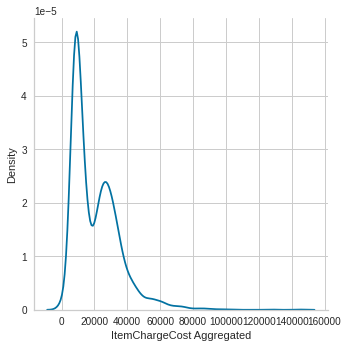

In [ ]:
plt.figure(figsize = (15,10))
sns.displot(joined_df, x="ItemChargeCost Aggregated", kind="kde")

In [ ]:
def extreme_removing(joined_df):
    df_lst = []
    extremes_lst = []
    for uniq_ops in joined_df["Operation"].unique():
        df = joined_df[joined_df["Operation"]==uniq_ops]
        q1, q3 = df["ItemChargeCost Aggregated"].quantile([0.25, 0.75])
        max_outlier = q3+1.5*(q3-q1)
        min_outlier = q1-1.5*(q3-q1)
        df_lst.append(df[df["ItemChargeCost Aggregated"]<max_outlier])
        extremes_lst.append(df[df["ItemChargeCost Aggregated"]>max_outlier])
        df_lst.append(df[df["ItemChargeCost Aggregated"]>min_outlier])
        extremes_lst.append(df[df["ItemChargeCost Aggregated"]<min_outlier])
    return df_lst, extremes_lst

joined_df_ = joined_df.copy()
joined_df = pd.concat(extreme_removing(joined_df_)[0])
joined_df.reset_index(drop=True, inplace=True)
extreme_df = pd.concat(extreme_removing(joined_df_)[1])
extreme_df.reset_index(drop=True, inplace=True)
extreme_df.to_excel("/home/huishan/Downloads/ramsay/removed_extreme.xlsx", index=False)
extreme_df

,MRN,Gender,Race,MaritalStatus,Weight,Height,BMI,Operation,Age In Years,Clinical History Clusters 0,...,Diagnosis Clusters 4,Diagnosis Clusters 5,Diagnosis Clusters 6,Diagnosis Clusters 7,Diagnosis Clusters 8,Diagnosis Clusters 9,ItemChargeCost Aggregated,Ordered Date Day,Ordered Date Month,NumYear
0,100077149,FEMALE,CHINESE,MARRIED,53.0,143.0,26.50000,LV/CORONARY ANGIOGRAM,85.801506,1,...,0,0,0,0,0,0,61125.25,1,3,0
1,100702546,MALE,MALAY,MARRIED,83.6,180.0,27.86667,LV/CORONARY ANGIOGRAM,51.170431,0,...,0,0,0,0,0,0,62311.20,30,3,0
2,100956233,MALE,CHINESE,MARRIED,71.8,165.0,23.93333,LV/CORONARY ANGIOGRAM,62.762491,0,...,0,0,0,0,0,0,73596.45,14,4,0
3,101283160,MALE,CHINESE,MARRIED,77.1,174.5,25.70000,LV/CORONARY ANGIOGRAM,57.727584,0,...,0,0,0,0,0,0,70789.90,17,4,0
4,101252437,MALE,CHINESE,MARRIED,55.0,165.0,18.33333,LV/CORONARY ANGIOGRAM,67.832991,0,...,0,0,0,0,0,0,64246.75,22,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,100606465,FEMALE,INDIAN,MARRIED,63.7,162.0,21.23333,LV/CORONARY ANGIOGRAM,67.624914,0,...,0,0,0,0,0,0,79614.85,11,9,3
61,100528742,MALE,CHINESE,MARRIED,73.0,167.0,24.33333,LV/CORONARY ANGIOGRAM,63.069131,0,...,0,0,0,0,0,0,71865.05,12,10,3
62,100105783,MALE,CHINESE,MARRIED,66.4,167.0,22.13333,LV/CORONARY ANGIOGRAM,67.159480,1,...,0,0,0,0,0,0,67424.30,23,10,3
63,100505173,MALE,CHINESE,SINGLE,77.0,168.0,25.66667,LV/CORONARY ANGIOGRAM,54.182067,1,...,0,0,0,0,0,0,61467.40,20,11,3


In [ ]:
tr_idx, val_idx = train_test_split(joined_df.index, test_size=.15, random_state=randomstate)
val_idx, tst_idx = train_test_split(val_idx, test_size=.4, random_state=randomstate)
training = joined_df.iloc[tr_idx]
validating = joined_df.iloc[val_idx]
testing = joined_df.iloc[tst_idx]
training.reset_index(drop=True, inplace=True)
validating.reset_index(drop=True, inplace=True)
testing.reset_index(drop=True, inplace=True)

In [ ]:
print("Training Set Shape:", training.shape)
print("Validating Set Shape:", validating.shape)
print("Testing Set Shape:", testing.shape)

Training Set Shape: (4917, 33)
Validating Set Shape: (520, 33)
Testing Set Shape: (348, 33)


In [ ]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
encoded_x = onehot_encoder.fit_transform(training[obj_cols])
training = pd.concat([training, pd.DataFrame(encoded_x.todense(), columns=onehot_encoder.get_feature_names())], axis=1)
training = training.drop(columns=obj_cols)

nan_cols = [col for col in training.columns if "nan" in col]   
training = training.drop(columns=nan_cols)
training.to_excel('/home/huishan/Downloads/training_1.xlsx', index=False)

training.fillna(0, inplace=True)

training.describe()

/home/huishan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,MRN,Weight,Height,BMI,Age In Years,Clinical History Clusters 0,Clinical History Clusters 1,Clinical History Clusters 2,Clinical History Clusters 3,Clinical History Clusters 4,...,x1_SIKH,x1_SINHALESE,x1_SINO-NATIVE,x1_SRI LANKA,x1_THAI,x2_DIVORCED,x2_MARRIED,x2_SINGLE,x2_WIDOWED,x3_LV/CORONARY ANGIOGRAM
count,4.917000e+03,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,...,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.0
mean,1.052753e+08,74.115371,165.528717,27.093848,60.883079,0.567419,0.052268,0.019727,0.079927,0.029896,...,0.005695,0.000814,0.000203,0.001627,0.000407,0.004068,0.861094,0.085825,0.006711,1.0
std,4.325796e+07,15.527066,10.097942,7.483919,10.353273,0.495484,0.222589,0.139076,0.271207,0.170318,...,0.075255,0.028513,0.014261,0.040307,0.020166,0.063654,0.345883,0.280133,0.081656,0.0
min,1.000008e+08,0.000000,0.000000,0.000000,22.464066,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.004071e+08,64.000000,160.000000,23.000000,53.954825,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
50%,1.009114e+08,72.900000,166.000000,26.000000,61.127995,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
75%,1.013265e+08,82.900000,172.000000,30.000000,67.578371,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0
max,6.000950e+08,170.000000,195.000000,170.000000,94.234086,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [ ]:
validating = pd.concat([validating, pd.DataFrame(onehot_encoder.transform(validating[obj_cols]).todense(), columns=onehot_encoder.get_feature_names())], axis=1)
validating = validating.drop(columns=obj_cols)
validating = validating.drop(columns=nan_cols)
validating.to_excel('/home/huishan/Downloads/validating_1.xlsx', index=False)

testing = pd.concat([testing, pd.DataFrame(onehot_encoder.transform(testing[obj_cols]).todense(), columns=onehot_encoder.get_feature_names())], axis=1)
testing = testing.drop(columns=obj_cols)
testing = testing.drop(columns=nan_cols)
testing.to_excel('/home/huishan/Downloads/testing_1.xlsx', index=False)

/home/huishan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/huishan/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
scaler = MinMaxScaler()
training[training.columns.difference(["MRN", "ItemChargeCost Aggregated"])] = scaler.fit_transform(training[training.columns.difference(["MRN", "ItemChargeCost Aggregated"])])
training.describe()

,MRN,Weight,Height,BMI,Age In Years,Clinical History Clusters 0,Clinical History Clusters 1,Clinical History Clusters 2,Clinical History Clusters 3,Clinical History Clusters 4,...,x1_SIKH,x1_SINHALESE,x1_SINO-NATIVE,x1_SRI LANKA,x1_THAI,x2_DIVORCED,x2_MARRIED,x2_SINGLE,x2_WIDOWED,x3_LV/CORONARY ANGIOGRAM
count,4.917000e+03,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,...,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.0
mean,1.052753e+08,0.435973,0.848865,0.159376,0.535307,0.567419,0.052268,0.019727,0.079927,0.029896,...,0.005695,0.000814,0.000203,0.001627,0.000407,0.004068,0.861094,0.085825,0.006711,0.0
std,4.325796e+07,0.091336,0.051784,0.044023,0.144256,0.495484,0.222589,0.139076,0.271207,0.170318,...,0.075255,0.028513,0.014261,0.040307,0.020166,0.063654,0.345883,0.280133,0.081656,0.0
min,1.000008e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.004071e+08,0.376471,0.820513,0.135294,0.438773,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
50%,1.009114e+08,0.428824,0.851282,0.152941,0.538720,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,1.013265e+08,0.487647,0.882051,0.176471,0.628595,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
max,6.000950e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


In [ ]:
validating[validating.columns.difference(["MRN", "ItemChargeCost Aggregated"])] = scaler.transform(validating[validating.columns.difference(["MRN", "ItemChargeCost Aggregated"])])
testing[testing.columns.difference(["MRN", "ItemChargeCost Aggregated"])] = scaler.transform(testing[testing.columns.difference(["MRN", "ItemChargeCost Aggregated"])])

In [ ]:
y_col = "ItemChargeCost Aggregated"
id_col = "MRN"
y = training[y_col]
x = training.drop(columns=y_col)
x = x.drop(columns=id_col)


val_y = validating[y_col]
val_x = validating.drop(columns=y_col)
val_x = val_x.drop(columns=id_col)

tst_y = testing[y_col]
tst_x = testing.drop(columns=y_col)
tst_x = tst_x.drop(columns=id_col)

In [ ]:
mdl_1 = sm.OLS(np.log(y), x)
res_1 = mdl_1.fit()
print(res_1.summary())

                                OLS Regression Results                               
Dep. Variable:     ItemChargeCost Aggregated   R-squared:                       0.135
Model:                                   OLS   Adj. R-squared:                  0.126
Method:                        Least Squares   F-statistic:                     15.16
Date:                       Tue, 02 Aug 2022   Prob (F-statistic):          5.27e-117
Time:                               15:21:24   Log-Likelihood:                -4925.7
No. Observations:                       4917   AIC:                             9953.
Df Residuals:                           4866   BIC:                         1.028e+04
Df Model:                                 50                                         
Covariance Type:                   nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [ ]:
ols_preds = res_1.predict(x)
print("MAE:", mean_absolute_error(y, np.exp(ols_preds)))
print("RMSE:", np.sqrt(mean_squared_error(y, np.exp(ols_preds))))
print("MAPE:", mean_absolute_percentage_error(y, np.exp(ols_preds)))
print("MSLE:", mean_squared_log_error(y, np.exp(ols_preds)))
print("RMSLE:", np.sqrt(mean_squared_log_error(y, np.exp(ols_preds))))

MAE: 10072.934299473049
RMSE: 13445.780147844114
MAPE: 1.2137186324144278
MSLE: 0.4334173690184642
RMSLE: 0.6583444151950134


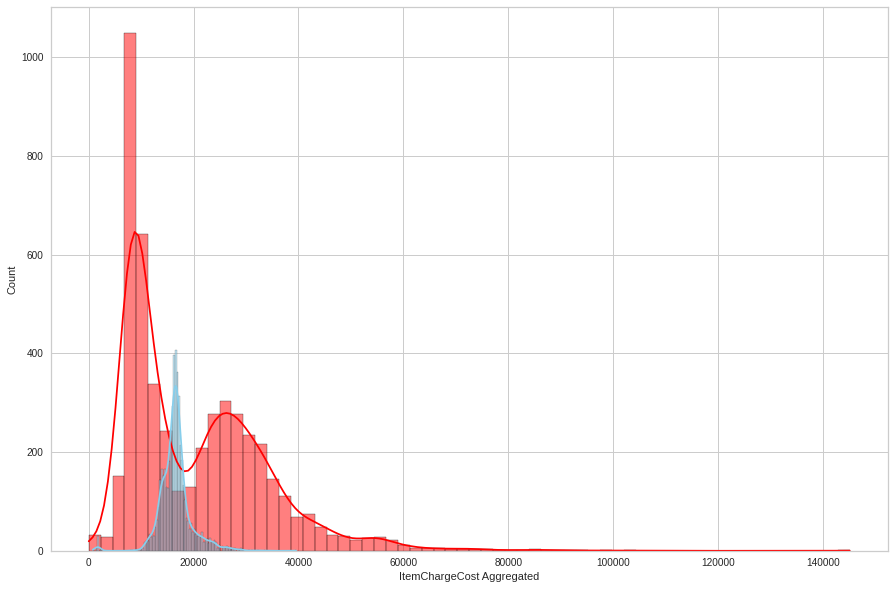

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(y, kde=True, color="red")
sns.histplot(np.exp(ols_preds), kde=True, color="skyblue")
plt.show()

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

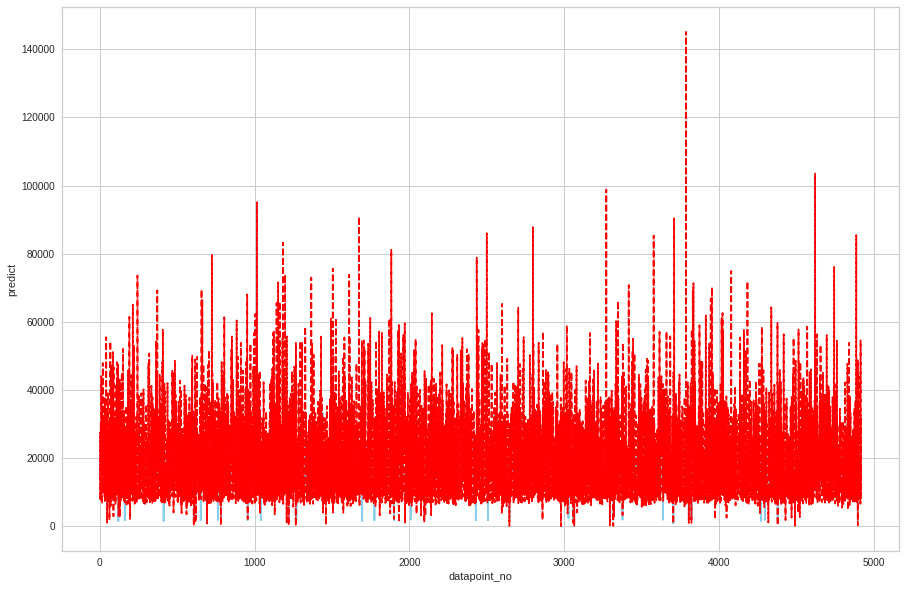

In [ ]:
plot_df = pd.DataFrame()
plot_df["datapoint_no"] = [i+1 for i in range(ols_preds.shape[0])]
plot_df["true_Charges"] = y.values
plot_df["predict"] = np.exp(ols_preds).tolist()
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=plot_df)
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=plot_df, linestyle='--')

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

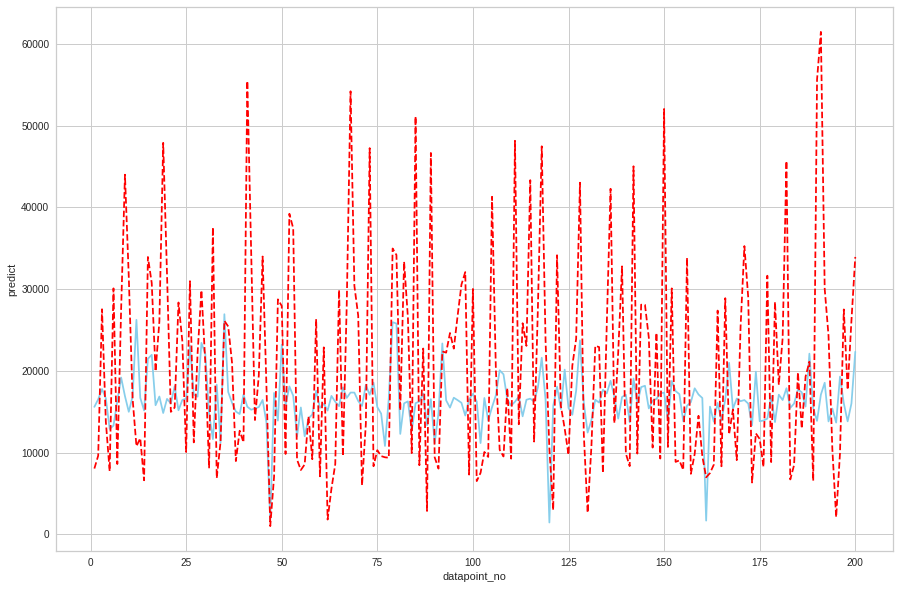

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=plot_df.iloc[:200])
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=plot_df.iloc[:200], linestyle='--')

In [ ]:
ols_preds = res_1.predict(val_x)
print("MAE:", mean_absolute_error(val_y, np.exp(ols_preds)))
print("RMSE:", np.sqrt(mean_squared_error(val_y, np.exp(ols_preds))))
print("MAPE:", mean_absolute_percentage_error(val_y, np.exp(ols_preds)))
print("MSLE:", mean_squared_log_error(val_y, np.exp(ols_preds)))
print("RMSLE:", np.sqrt(mean_squared_log_error(val_y, np.exp(ols_preds))))

MAE: 10013.158856742039
RMSE: 13485.163465623213
MAPE: 6.137081348600106
MSLE: 0.5354803371908967
RMSLE: 0.7317652199926536


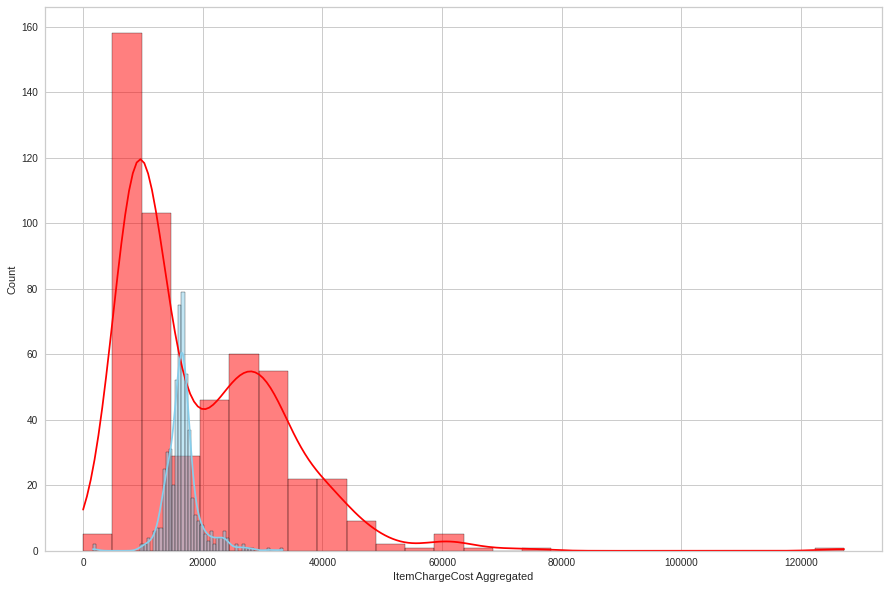

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(val_y, kde=True, color="red")
sns.histplot(np.exp(ols_preds).tolist(), kde=True, color="skyblue")
plt.show()

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

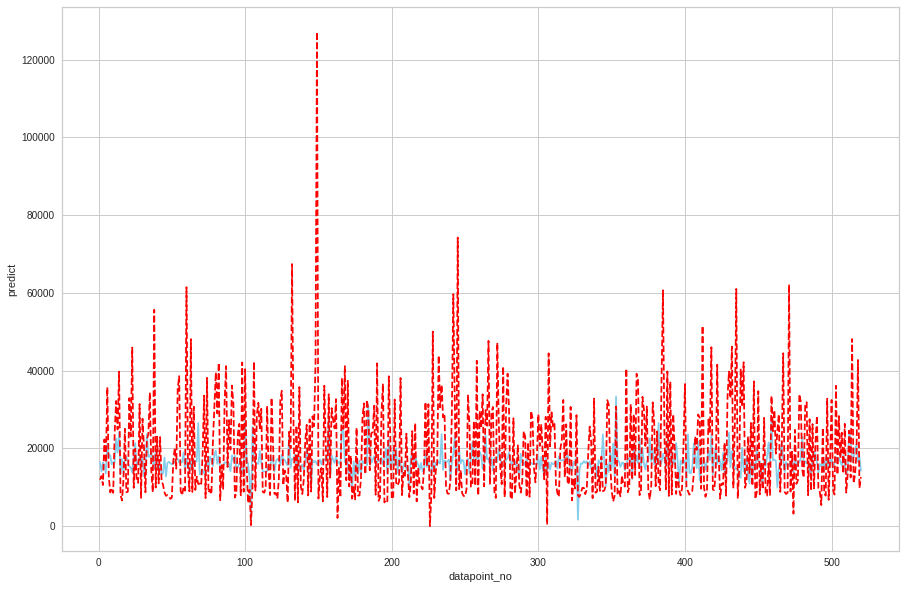

In [ ]:
plot_df = pd.DataFrame()
plot_df["datapoint_no"] = [i+1 for i in range(ols_preds.shape[0])]
plot_df["true_Charges"] = val_y.values
plot_df["predict"] = np.exp(ols_preds).tolist()
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=plot_df)
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=plot_df, linestyle='--')

In [ ]:
h2o.init()
joined_df_2 = pd.concat([x,y], axis=1)
joined_df_2["ItemChargeCost Aggregated"] = np.log(joined_df_2["ItemChargeCost Aggregated"])
h2o_df = h2o.H2OFrame(joined_df_2)
automl = H2OAutoML(max_runtime_secs=60*5, seed=randomstate)
automl.train(x=list(x.columns), y='ItemChargeCost Aggregated', training_frame=h2o_df)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 32 mins
H2O_cluster_timezone:,Asia/Kuala_Lumpur
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,7 months and 12 days !!!
H2O_cluster_name:,H2O_from_python_huishan_dd1rwo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.490 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:21:27.79: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

██
15:21:31.82: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]
15:21:32.84: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

█
15:21:35.87: _train param, Dropping unused columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

█
15:21:36.91: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

█
15:21:40.93: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

██
15:21:46.97: _train param, Dropping bad and constant columns: [Diagnosis Clusters

,,number_of_trees
0,,104.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0017473508371224917
RMSE: 0.04180132578187553
MAE: 0.01441824773183702
RMSLE: 0.00783738129284397
Mean Residual Deviance: 0.0017473508371224917

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.18426652894883608
RMSE: 0.4292627737748011
MAE: 0.21510912961341125
RMSLE: 0.043569251857952296
Mean Residual Deviance: 0.18426652894883608

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.215112,0.015232,0.189746,0.228154,0.224465,0.213236,0.219958
1,mean_residual_deviance,0.184274,0.030725,0.139113,0.191632,0.179247,0.224924,0.186455
2,mse,0.184274,0.030725,0.139113,0.191632,0.179247,0.224924,0.186455
3,r2,0.630004,0.067987,0.725316,0.661405,0.577486,0.554774,0.631037
4,residual_deviance,0.184274,0.030725,0.139113,0.191632,0.179247,0.224924,0.186455
5,rmse,0.428036,0.036395,0.372979,0.437758,0.423375,0.474261,0.431804
6,rmsle,0.042877,0.008661,0.035362,0.041000,0.039516,0.057839,0.040669



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-02 15:23:53,1 min 13.713 sec,0.0,9.217999,9.190741,84.971506
1,,2022-08-02 15:23:53,1 min 13.732 sec,5.0,1.698194,1.571388,2.883862
2,,2022-08-02 15:23:53,1 min 13.742 sec,10.0,0.686884,0.566936,0.471810
3,,2022-08-02 15:23:53,1 min 13.760 sec,15.0,0.511021,0.423124,0.261143
4,,2022-08-02 15:23:53,1 min 13.779 sec,20.0,0.395203,0.314418,0.156186
5,,2022-08-02 15:23:53,1 min 13.805 sec,25.0,0.316110,0.241884,0.099925
6,,2022-08-02 15:23:53,1 min 13.829 sec,30.0,0.261172,0.189808,0.068211
7,,2022-08-02 15:23:54,1 min 13.855 sec,35.0,0.217134,0.151409,0.047147
8,,2022-08-02 15:23:54,1 min 13.885 sec,40.0,0.189698,0.127936,0.035985
9,,2022-08-02 15:23:54,1 min 13.913 sec,45.0,0.163883,0.106781,0.026858



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Weight,649.105103,1.000000,0.166314
1,Age In Years,540.432983,0.832582,0.138470
2,Ordered Date Day,540.137085,0.832126,0.138394
3,BMI,441.075623,0.679513,0.113013
4,Height,372.256958,0.573493,0.095380
5,Ordered Date Month,359.193726,0.553368,0.092033
6,Diagnosis Clusters 0,259.405579,0.399636,0.066465
7,NumYear,150.361694,0.231645,0.038526
8,Clinical History Clusters 0,66.675842,0.102720,0.017084
9,Diagnosis Clusters 1,60.526386,0.093246,0.015508



See the whole table with table.as_data_frame()


In [ ]:
automl.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid_1_AutoML_12_20220802_152127_model_13,0.184267,0.429263,0.184267,0.215109,0.0435693
GBM_grid_1_AutoML_12_20220802_152127_model_14,0.189054,0.434804,0.189054,0.241713,0.0442129
StackedEnsemble_AllModels_3_AutoML_12_20220802_152127,0.189163,0.434928,0.189163,0.272315,0.0444889
XGBoost_grid_1_AutoML_12_20220802_152127_model_20,0.189915,0.435793,0.189915,0.235567,0.0442926
StackedEnsemble_BestOfFamily_5_AutoML_12_20220802_152127,0.19176,0.437905,0.19176,0.279704,0.0448272
StackedEnsemble_BestOfFamily_4_AutoML_12_20220802_152127,0.19182,0.437973,0.19182,0.279806,0.0448402
XGBoost_grid_1_AutoML_12_20220802_152127_model_11,0.195709,0.44239,0.195709,0.219393,0.0446179
GBM_grid_1_AutoML_12_20220802_152127_model_9,0.200185,0.44742,0.200185,0.267739,0.0454416
XGBoost_grid_1_AutoML_12_20220802_152127_model_16,0.201505,0.448893,0.201505,0.230389,0.0453314
XGBoost_grid_1_AutoML_12_20220802_152127_model_18,0.202345,0.449828,0.202345,0.238003,0.0455705


In [ ]:
# automl.explain(h2o_df)

In [ ]:
train_eval = h2o.H2OFrame(joined_df_2.drop(columns=y_col))
train_preds = np.exp(automl.predict(train_eval).as_data_frame())
train_y = np.exp(joined_df_2[y_col])
print("R squared:", r2_score(train_y, train_preds))
print("MAE:", mean_absolute_error(train_y, train_preds))
print("RMSE:", np.sqrt(mean_squared_error(train_y, train_preds)))
print("MAPE:", mean_absolute_percentage_error(train_y, train_preds))
print("MSLE:", mean_squared_log_error(train_y, train_preds))
print("RMSLE:", np.sqrt(mean_squared_log_error(train_y, train_preds)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
R squared: 0.9911055686716815
MAE: 344.0391419127936
RMSE: 1257.4242873155274
MAPE: 0.014982452461120973
MSLE: 0.0016511017380928476
RMSLE: 0.040633751218572566


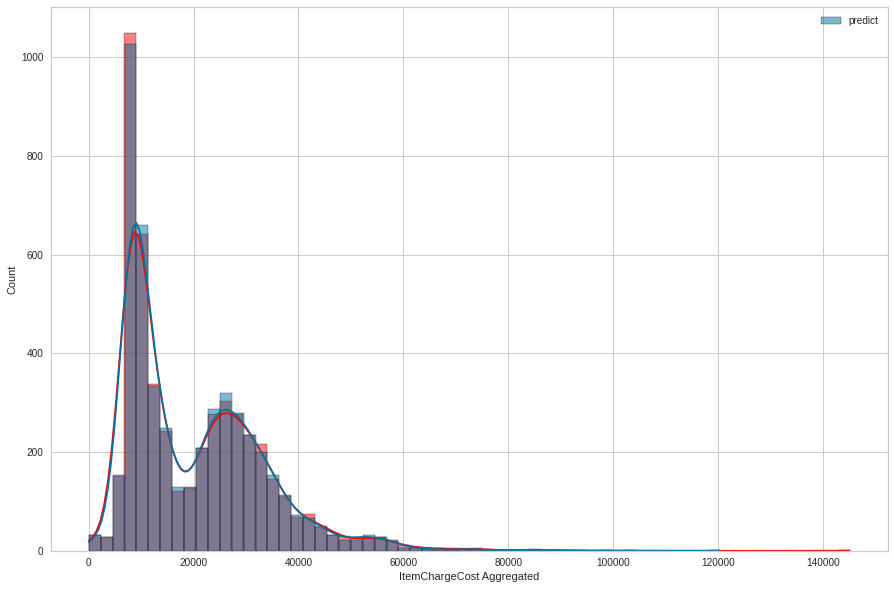

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(train_y, kde=True, color="red")
sns.histplot(train_preds, kde=True, color="skyblue")
plt.show()

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

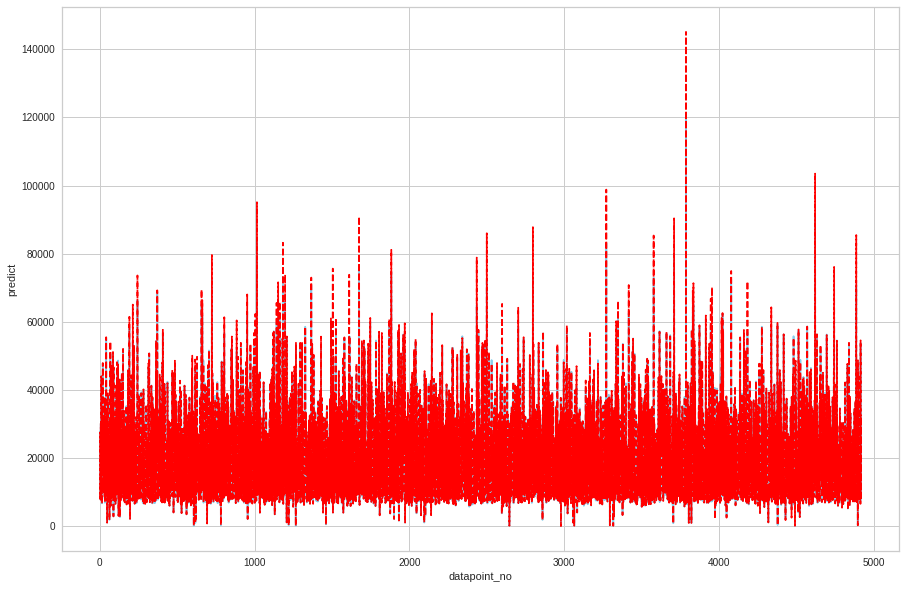

In [ ]:
train_preds['datapoint_no'] = [i+1 for i in range(train_preds.shape[0])]
train_preds['true_Charges'] = train_y
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=train_preds)
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=train_preds, linestyle='--')

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

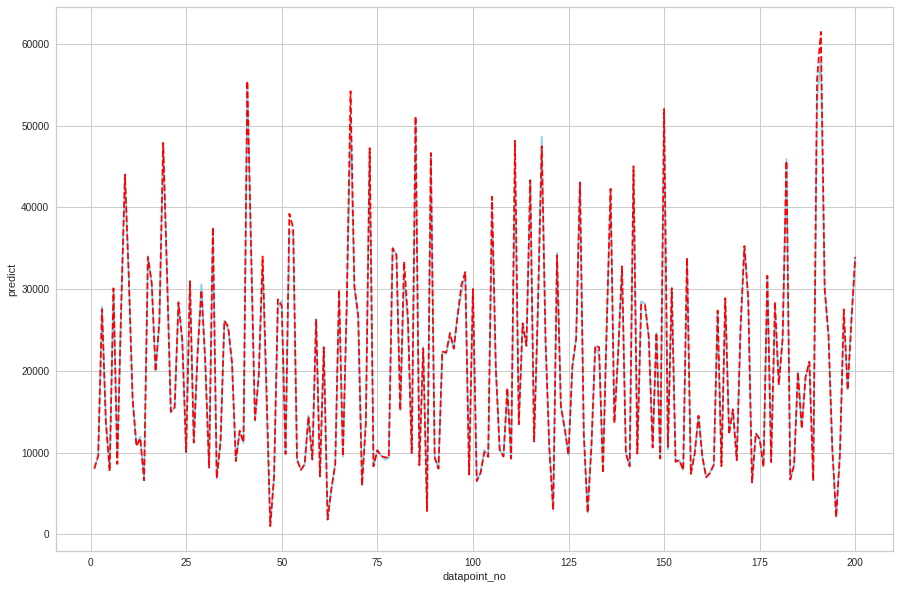

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=train_preds.iloc[:200])
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=train_preds.iloc[:200], linestyle='--')

In [ ]:
joined_df_3 = pd.concat([val_x, val_y], axis=1)
joined_df_3.reset_index(drop=True, inplace=True)
val_df = h2o.H2OFrame(joined_df_3.drop(columns=y_col))
val_preds = np.exp(automl.predict(val_df).as_data_frame())
print("MAE:", mean_absolute_error(val_y, val_preds))
print("RMSE:", np.sqrt(mean_squared_error(val_y, val_preds)))
print("MAPE:", mean_absolute_percentage_error(val_y, val_preds))
print("MSLE:", mean_squared_log_error(val_y, val_preds))
print("RMSLE:", np.sqrt(mean_squared_log_error(val_y, val_preds)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
MAE: 2646.5495925168493
RMSE: 8477.60656990439
MAPE: 0.13174366651900649
MSLE: 0.0999141022471138
RMSLE: 0.316091920566018


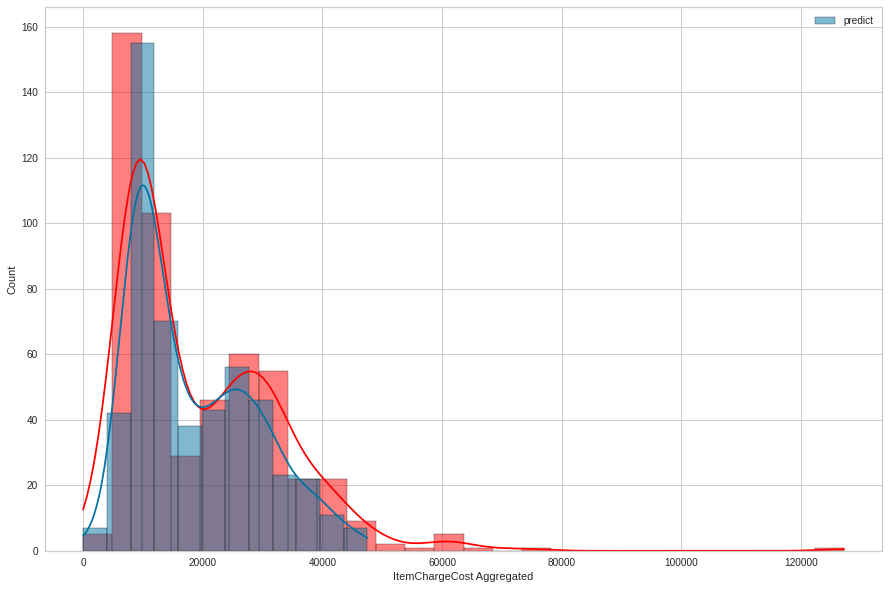

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(val_y, kde=True, color="red")
sns.histplot(val_preds, kde=True, color="skyblue")
plt.show()

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

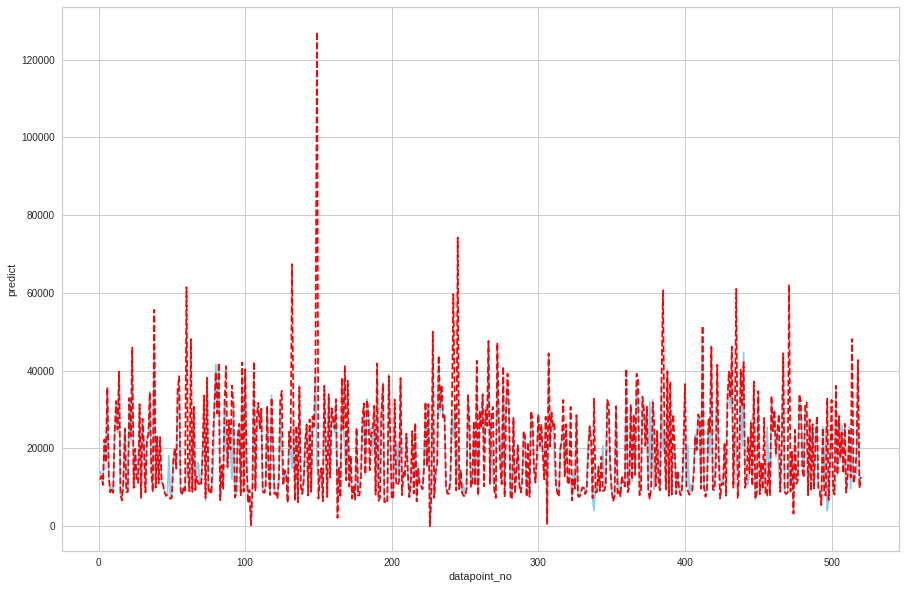

In [ ]:
val_preds['datapoint_no'] = [i+1 for i in range(val_preds.shape[0])]
val_preds['true_Charges'] = val_y
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=val_preds)
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=val_preds, linestyle="--")

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

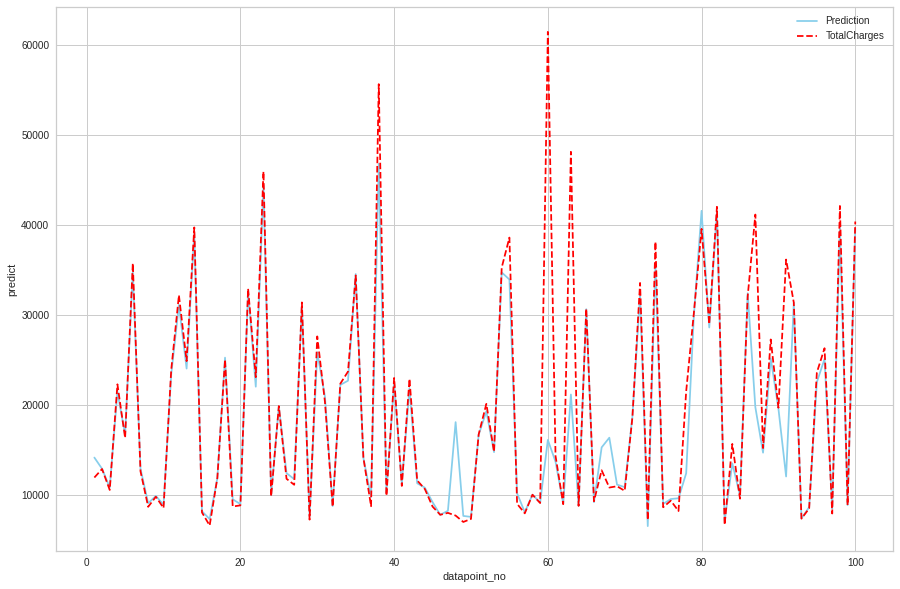

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='skyblue', data=val_preds.iloc[:100], label='Prediction')
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=val_preds.iloc[:100], linestyle="--", label="TotalCharges")

In [ ]:
retrain_x = pd.concat([x, val_x], axis=0)
retrain_y = pd.concat([y, val_y], axis=0)
joined_df_4 = pd.concat([retrain_x, retrain_y], axis=1)
del retrain_x, retrain_y

joined_df_4.reset_index(drop=True, inplace=True)
joined_df_4[y_col] = np.log(joined_df_4[y_col])
tst_df = h2o.H2OFrame(joined_df_4)
automl_retrain = H2OAutoML(max_runtime_secs=60*5, seed=randomstate)
automl_retrain.train(x=list(x.columns), y=y_col, training_frame=tst_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:26:31.638: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

██
15:26:37.641: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]


15:26:38.645: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

██
15:26:42.648: _train param, Dropping unused columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]
15:26:43.651: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

█
15:26:47.654: _train param, Dropping bad and constant columns: [Diagnosis Clusters 9, Diagnosis Clusters 4, x3_LV/CORONARY ANGIOGRAM]

███
15:26:54.657: _train param, Dropping bad and constant columns: [Diagnosis 

,,number_of_trees
0,,92.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.0004644930463309479
RMSE: 0.021552100740553064
MAE: 0.008398310279109493
RMSLE: 0.0019614198921781264
Mean Residual Deviance: 0.0004644930463309479

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 0.14713622748536997
RMSE: 0.38358340355830045
MAE: 0.1756250699565804
RMSLE: 0.03602254025187279
Mean Residual Deviance: 0.14713622748536997

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.175627,0.010958,0.156970,0.183447,0.182916,0.174990,0.179812
1,mean_residual_deviance,0.147140,0.017223,0.119910,0.154670,0.163346,0.141155,0.156618
2,mse,0.147140,0.017223,0.119910,0.154670,0.163346,0.141155,0.156618
3,r2,0.710782,0.038082,0.766160,0.719290,0.665428,0.716233,0.686799
4,residual_deviance,0.147140,0.017223,0.119910,0.154670,0.163346,0.141155,0.156618
5,rmse,0.383036,0.023009,0.346280,0.393281,0.404160,0.375706,0.395750
6,rmsle,0.035962,0.002336,0.032032,0.036687,0.037967,0.035813,0.037313



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-08-02 15:29:31,1 min 27.926 sec,0.0,9.215286,9.187572,84.921495
1,,2022-08-02 15:29:31,1 min 27.944 sec,5.0,1.648998,1.553796,2.719194
2,,2022-08-02 15:29:31,1 min 27.958 sec,10.0,0.533829,0.426724,0.284974
3,,2022-08-02 15:29:31,1 min 27.974 sec,15.0,0.341568,0.269070,0.116668
4,,2022-08-02 15:29:31,1 min 27.992 sec,20.0,0.284466,0.216949,0.080921
5,,2022-08-02 15:29:31,1 min 28.010 sec,25.0,0.211959,0.155644,0.044927
6,,2022-08-02 15:29:31,1 min 28.026 sec,30.0,0.182038,0.130457,0.033138
7,,2022-08-02 15:29:31,1 min 28.045 sec,35.0,0.153886,0.105938,0.023681
8,,2022-08-02 15:29:31,1 min 28.065 sec,40.0,0.128085,0.085448,0.016406
9,,2022-08-02 15:29:31,1 min 28.085 sec,45.0,0.100308,0.064819,0.010062



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Age In Years,698.897644,1.000000,0.146954
1,Ordered Date Day,693.733704,0.992611,0.145869
2,Weight,616.823730,0.882567,0.129697
3,BMI,607.350830,0.869013,0.127705
4,Height,469.326324,0.671524,0.098683
5,Ordered Date Month,380.773468,0.544820,0.080064
6,Diagnosis Clusters 0,339.939240,0.486393,0.071478
7,NumYear,249.602325,0.357137,0.052483
8,x1_CHINESE,102.273972,0.146336,0.021505
9,x0_FEMALE,89.658340,0.128285,0.018852



See the whole table with table.as_data_frame()


In [ ]:
automl_retrain.leaderboard

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_grid_1_AutoML_13_20220802_152631_model_11,0.147136,0.383583,0.147136,0.175625,0.0360225
StackedEnsemble_AllModels_3_AutoML_13_20220802_152631,0.150039,0.387349,0.150039,0.23033,0.037411
StackedEnsemble_BestOfFamily_4_AutoML_13_20220802_152631,0.151783,0.389594,0.151783,0.236248,0.0379073
GBM_grid_1_AutoML_13_20220802_152631_model_9,0.155273,0.394047,0.155273,0.224241,0.0383864
XGBoost_2_AutoML_13_20220802_152631,0.161656,0.402065,0.161656,0.191142,0.0379194
StackedEnsemble_AllModels_2_AutoML_13_20220802_152631,0.162238,0.402787,0.162238,0.243605,0.039275
StackedEnsemble_AllModels_1_AutoML_13_20220802_152631,0.162567,0.403196,0.162567,0.243966,0.0393789
StackedEnsemble_BestOfFamily_3_AutoML_13_20220802_152631,0.16447,0.405549,0.16447,0.250793,0.0396907
StackedEnsemble_BestOfFamily_2_AutoML_13_20220802_152631,0.1648,0.405956,0.1648,0.251208,0.0397778
XGBoost_grid_1_AutoML_13_20220802_152631_model_10,0.166737,0.408334,0.166737,0.223034,0.0386757


In [ ]:
train_eval = h2o.H2OFrame(joined_df_4.drop(columns=y_col))
train_preds = np.exp(automl_retrain.predict(train_eval).as_data_frame())
train_y = np.exp(joined_df_4[y_col])
print("R squared:", r2_score(train_y, train_preds))
print("MAE:", mean_absolute_error(train_y, train_preds))
print("RMSE:", np.sqrt(mean_squared_error(train_y, train_preds)))
print("MAPE:", mean_absolute_percentage_error(train_y, train_preds))
print("MSLE:", mean_squared_log_error(train_y, train_preds))
print("RMSLE:", np.sqrt(mean_squared_log_error(train_y, train_preds)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
R squared: 0.9958227662289211
MAE: 204.40688518834452
RMSE: 862.1899291440404
MAPE: 0.00837239689212516
MSLE: 0.0004644285413123526
RMSLE: 0.021550604198313155


In [ ]:
joined_df_5 = tst_x
joined_df_5.reset_index(drop=True, inplace=True)
tst_eval = h2o.H2OFrame(joined_df_5)
tst_preds = np.exp(automl_retrain.predict(tst_eval).as_data_frame())

print("MAE:", mean_absolute_error(tst_y, tst_preds))
print("RMSE:", np.sqrt(mean_squared_error(tst_y, tst_preds)))
print("MAPE:", mean_absolute_percentage_error(tst_y, tst_preds))
print("MSLE:", mean_squared_log_error(tst_y, tst_preds))
print("RMSLE:", np.sqrt(mean_squared_log_error(tst_y, tst_preds)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
MAE: 869.8620224728382
RMSE: 2561.932204068007
MAPE: 0.051615778361872026
MSLE: 0.02316902205845855
RMSLE: 0.15221373807399433


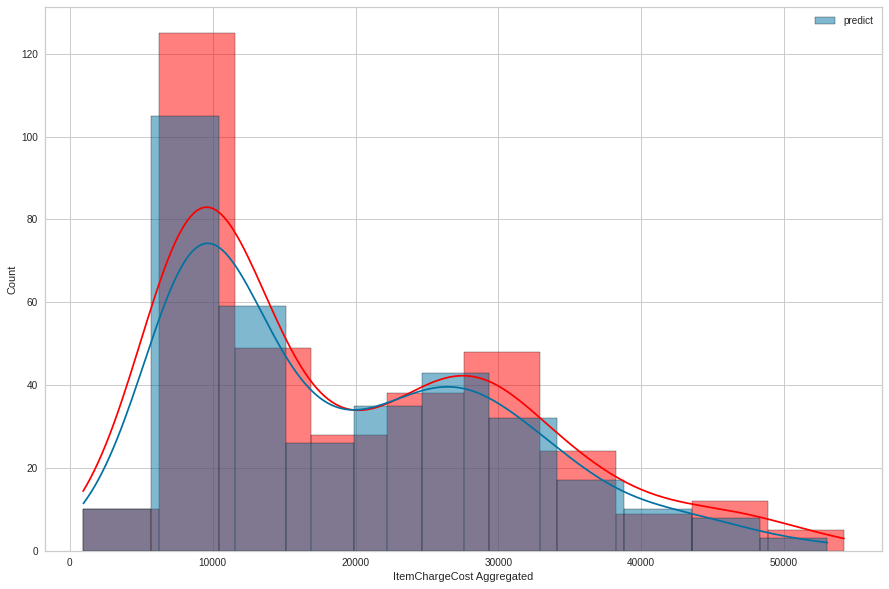

In [ ]:
plt.figure(figsize = (15,10))
sns.histplot(tst_y, kde=True, color="red")
sns.histplot(tst_preds, kde=True, color="skyblue")
plt.show()

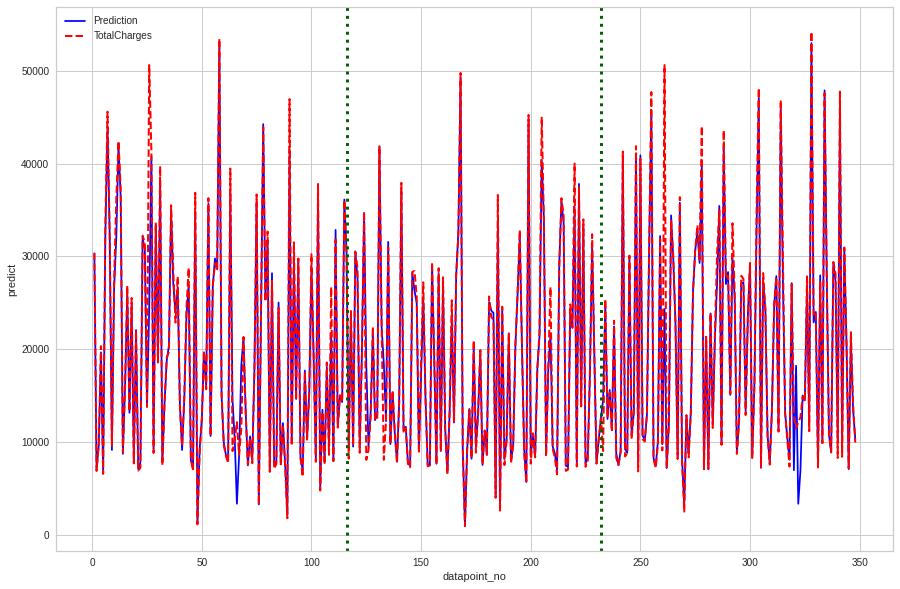

In [ ]:
tst_preds['datapoint_no'] = [i+1 for i in range(tst_preds.shape[0])]
tst_preds['true_Charges'] = tst_y
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='blue', data=tst_preds, label="Prediction")
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=tst_preds, linewidth=2, linestyle="--", label="TotalCharges")
plt.axvline(x=116, color='darkgreen', linestyle='dotted', linewidth=3)
plt.axvline(x=232, color='darkgreen', linestyle='dotted', linewidth=3)

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

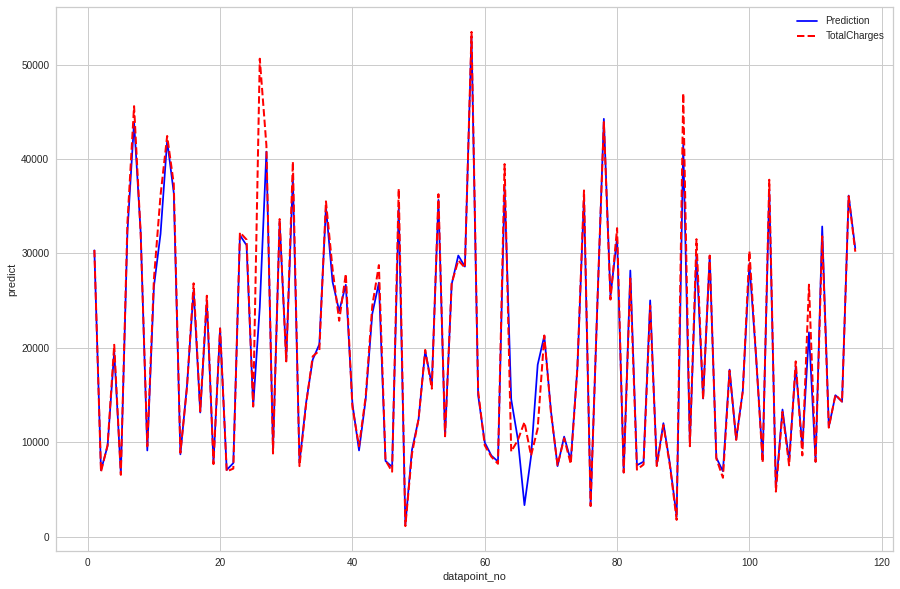

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='blue', data=tst_preds.iloc[:116], label="Prediction")
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=tst_preds.iloc[:116], linewidth=2, linestyle="--", label="TotalCharges")

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

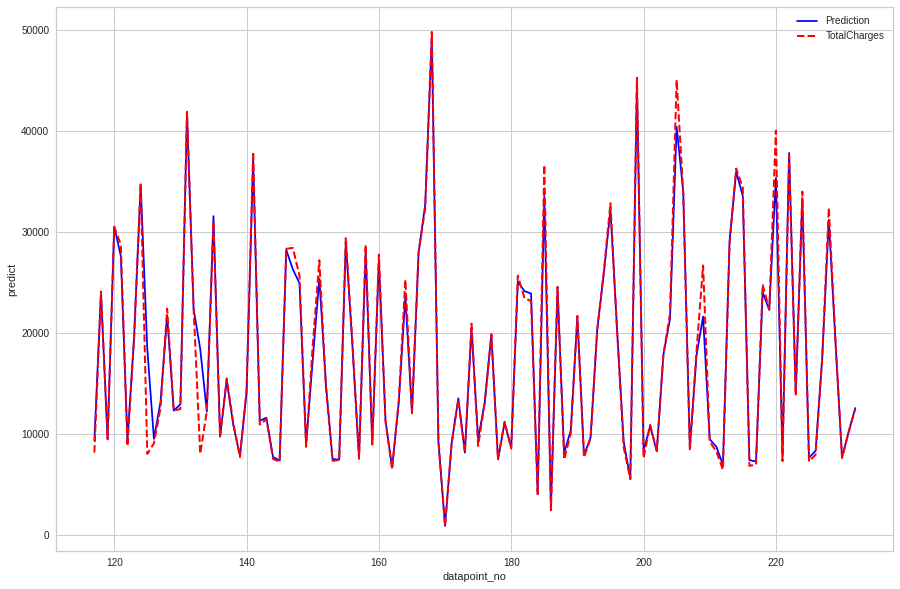

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='blue', data=tst_preds.iloc[116:232], label="Prediction")
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=tst_preds.iloc[116:232], linewidth=2, linestyle="--", label="TotalCharges")

<AxesSubplot:xlabel='datapoint_no', ylabel='predict'>

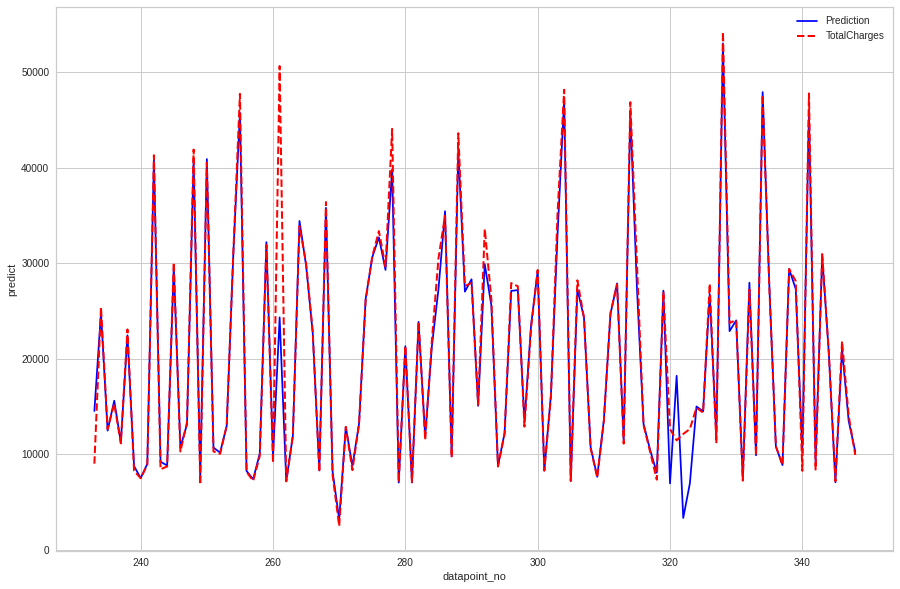

In [ ]:
plt.figure(figsize = (15,10))
sns.lineplot(y="predict", x='datapoint_no', color='blue', data=tst_preds.iloc[232:], label="Prediction")
sns.lineplot(y="true_Charges", x='datapoint_no', color='red', data=tst_preds.iloc[232:], linestyle="--", linewidth=2, label="TotalCharges")

In [ ]:
diff = tst_preds.predict-tst_y.values
print("Percentage of Underestimation", len(diff[diff<0])/len(diff))

Percentage of Underestimation 0.48563218390804597
